<img style="float: right;" src="../images/meetup_logo.svg" width=200>

# Meetup - Regression Models (Sep-Oct 2018)


<i>Predicting RSVP count using regression models</i>

<u>Models:</u>
1. <a href='#baseline'>Multivariate Linear Regression</a> (baseline) 
2. <a href='#reg'>Regularization Regressions</a> 
3. <a href='#support'>Support Vector Regression</a> 
4. <a href='#random'>Random Forest Regression</a> 
5. <a href ='#boost'>XGBoost Regression</a>
6. <a href ='#sgd'>SGD Regression</a>
7. <a href ='#stacked'>Stacked Model</a>

<u>Performance Summary</u>:

|<p style='text-align:left;'>Model</p>|<p style='text-align:left;'>Details</p>| $R^2$ | RMSE|
| ----------------------------- | ----------------------- | ---- |----|
|<p style='text-align:left;'>Linear Regression</p>           |<p style='text-align:left;'>Baseline</p>                | 0.21 |  21  |
|<p style='text-align:left;'>Linear Regression</p>  |<p style='text-align:left;'>w/ engineered features and interactions </p> | 0.34 | 20    |
|<p style='text-align:left;'>Ridge Regression</p>  |<p style='text-align:left;'>alpha = 0.5</p> | 0.34 |20 |
|<p style='text-align:left;'>Lasso Regression</p>  |<p style='text-align:left;'>alpha = 0.001</p> | 0.34 |20|
|<p style='text-align:left;'>Support Vector Regression</p>  |<p style='text-align:left;'>(kernel: rbf, C: 100)</p> | 0.67 | 14 |
|<p style='text-align:left;'>Random Forest Regression</p> |<p style='text-align:left;'>(max_depth=14, random_state=0, n_estimators=300, criterion = 'mse', min_samples_split = 2)</p>| 0.78 | 14|
|<p style='text-align:left;'>XGBoost  Regression</p>|<p style='text-align:left;'>(gamma: 0, learning_rate: 0.1, max_depth: 9, learning_rate: 0.1, n_estimators: 300)</p>| 0.85 | 12 |
|<p style='text-align:left;'>SGD  Regression</p>  |<p style='text-align:left;'> (learning_rate: 'invscaling', loss: 'huber', penalty: 'elasticnet')</p>| 0.31 |19  |
|<p style='text-align:left;'>Stacked Linear Regression</p>  |<p style='text-align:left;'> Base models: RF, XGB, SVR</p>| 0.84 | 12 |

***

## 0. Import libraries & data

#### Importing libraries

In [2]:
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from regression_functions import mean_normalize, get_hist, get_corr_heatmap, get_linear_assumptions_graphs, plot_feature_importances, lasso_alpha, ridge_alpha, get_residual_plot
import time
import datetime
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score
import xgboost
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')
%matplotlib inline

#### Preview data

In [3]:
# import dataset
df_regression = pd.read_pickle('df_sepoct_events_groups_merged_cleaned.pickle')
df_regression.head()

,event_created,event_description,event_duration,event_url,fee,group,event_headcount,how_to_find_us,event_id,maybe_rsvp_count,...,group_state,group_status,group_urlname,group_visibility,group_who,group_category,group_organizer_id,group_yrs_est,group_created_date,num_past_events
0,1535391367000,Join us in person or tune in online! Livestrea...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor/ stream online at ...,254149786,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
1,1535385547000,Get started now on challenges related to these...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,https://zoom.us/j/417883916,254146381,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
2,1535392484000,In this workshop we’ll get a clear sense of th...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor / Livestream at ht...,254150230,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
3,1531947994000,The number of opportunities for software engin...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to the 2nd floor,252915161,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
4,1535383458000,Please tune into the stream here: https://zoom...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please tune into the stream here: https://zoom...,254144933,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38


In [4]:
df_regression.shape

(25424, 58)

In [145]:
df_regression.columns

Index(['event_created', 'event_description', 'event_duration', 'event_url',
       'fee', 'group', 'event_headcount', 'how_to_find_us', 'event_id',
       'maybe_rsvp_count', 'event_name', 'photo_url', 'event_rating',
       'rsvp_limit', 'event_status', 'event_time', 'event_updated',
       'utc_offset', 'event_visibility', 'waitlist_count', 'why',
       'yes_rsvp_count', 'group_is_open', 'group_id', 'has_how_to_find',
       'has_rsvp_limit', 'event_num_words', 'has_photo', 'venue_latlon',
       'time_datetime', 'time_m_d_y', 'day_of_week', 'event_hour',
       'event_hour_group', 'subway_distances', 'num_close_subways',
       'has_event_fee', 'created_to_event_days', 'group_created',
       'group_description', 'group_join_mode', 'group_lat', 'group_link',
       'localized_country_name', 'localized_location', 'group_lon',
       'num_members', 'group_name', 'group_state', 'group_status',
       'group_urlname', 'group_visibility', 'group_who', 'group_category',
       'group_org

<a id='baseline'></a>
## 1. Multivariate Linear Regession

#### Baseline Model

For the baseline model, we'll use just the features that came with the data:

<p style='text-align: left;'>Dependent</p>      |<p style='text-align: left;'>Independent - numerical</p>|<p style='text-align: center;'>Independent - categorical</p>
:------------- |:---------------------------------------------- |:------------------------- 
<p style='text-align: left;'>number yes rsvps</p> |<p style='text-align: left;'>number of members in group hosting event</p>        |<p style='text-align: left;'>group category</p>
               |<p style='text-align: left;'>number of past events</p>                           |
               |<p style='text-align: left;'>duration of the event</p>               |
               
<u>Hypotheses</u>:
- $H_{0}$: there is no relationship between the dependent and independent variables
- $H_{a}$: there is a relationship between the dependent and independent variables


<u>Process</u>:
1. Create dataframe with target and baseline features only.
2. Analyze features to see whether the four assumptions of a linear model are met (no multicollinearity, normality, linearity, homoscedasticity).
3. Build baseline model.


In [146]:
# create dataframe with target and baseline variables only
df_baseline = df_regression[['yes_rsvp_count', 'num_members', 'num_past_events', 'event_duration', 'group_category']]
df_baseline.head()

,yes_rsvp_count,num_members,num_past_events,event_duration,group_category
0,42,8050,38,120.0,tech
1,64,8050,38,150.0,tech
2,83,8050,38,150.0,tech
3,113,8050,38,120.0,tech
4,21,8050,38,120.0,tech


<i>Handling Categorical Data</i>

We have one categorical feature, ```group_category```, which we will dummify (or one-hot-encode) before running in the linear regression model. This will convert each unique category into a new column and assign a 1 for observations that fall under that particular category, else 0 for all other categories.

Another option here is label encoding, which assigns a number to each category so that numbers are between 0 and $number of categories - 1$. The upside of this method is that additional columns are not added to dataset. However, there is a risk that the model might view the numerical representations of the categories as actual numbers, thus potentially deriving some relationship between the numbers and the rows of data when there actually is no relationship at all.

Because the ```group_category``` has 33 unique categories, we'll use the dummy-method to avoid potentially adding noise to our dataset. We will drop one of the dummy columns as is standard practice in label-encoding for a vanilla linear regression (i.e. without any regularization). 

In [147]:
# make sure dtype of group_category is 'category' and make sure to drop one
df_baseline['group_category'] = df_baseline['group_category'].apply(lambda x: x.replace('-', '_'))
df_baseline['group_category'] = df_baseline['group_category'].astype('category')
group_category_dummies = pd.get_dummies(df_baseline['group_category'], drop_first=True)

In [148]:
group_category_dummies.head()

,book_clubs,career_business,cars_motorcycles,community_environment,dancing,education_learning,fashion_beauty,fitness,food_drink,games,...,pets_animals,photography,religion_beliefs,sci_fi_fantasy,singles,socializing,sports_recreation,support,tech,writing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [149]:
# merge the dummies to the baseline dataframe
df_baseline_w_dummies = pd.concat([df_baseline, group_category_dummies], axis = 1)

In [150]:
df_baseline_w_dummies.head()

,yes_rsvp_count,num_members,num_past_events,event_duration,group_category,book_clubs,career_business,cars_motorcycles,community_environment,dancing,...,pets_animals,photography,religion_beliefs,sci_fi_fantasy,singles,socializing,sports_recreation,support,tech,writing
0,42,8050,38,120.0,tech,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,64,8050,38,150.0,tech,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,83,8050,38,150.0,tech,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,113,8050,38,120.0,tech,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,21,8050,38,120.0,tech,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [151]:
df_baseline_w_dummies.drop(columns='group_category', inplace =True)

<i>Multicollinearity</i>

According to the correlation heatmap below of our numerical features, there is no strong correlation ($r$ > 0.75) within the numerical features. This means we can keep all of these features in our model.

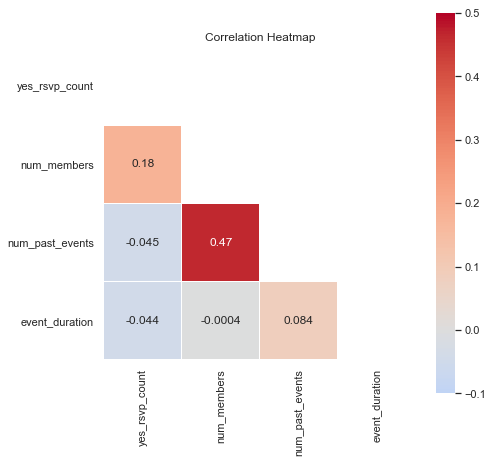

In [152]:
get_corr_heatmap(df_baseline)

Based on the pair-plot below, ```yes_rsvp_count```, ```num_members```, and ```num_past_events``` seem to be a bit normally distributed but with a strong right-skew. We will perform a log transformation on these values to reduce the skew.

```event_duration``` is not normally distributed but we'll see how the log transofrmation works on this as well.


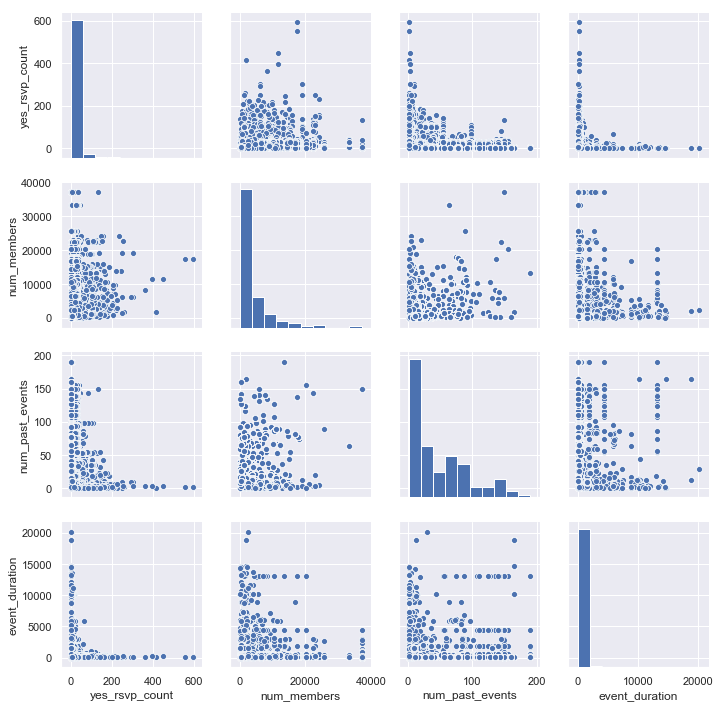

In [153]:
sns.set(style= 'darkgrid')
# sns.pairplot(df_baseline, hue = 'group_category', palette = 'muted', height = 3.5)
sns.pairplot(df_baseline)

In [154]:
df_baseline_w_dummies.columns

Index(['yes_rsvp_count', 'num_members', 'num_past_events', 'event_duration',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [155]:
# log-transforming all numerical features
df_baseline_w_dummies['log_yes_rsvp_count'] = np.log(df_baseline_w_dummies['yes_rsvp_count']+1)
df_baseline_w_dummies['log_num_members'] = np.log(df_baseline_w_dummies['num_members']+1)
df_baseline_w_dummies['log_num_past_events'] = np.log(df_baseline_w_dummies['num_past_events']+1)
df_baseline_w_dummies['log_event_duration'] = np.log(df_baseline_w_dummies['event_duration']+1)

In [156]:
# mean-normalizing all numerical features
df_baseline_w_dummies['munorm_yes_rsvp_count'] = df_baseline_w_dummies['yes_rsvp_count'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['yes_rsvp_count']))
df_baseline_w_dummies['munorm_num_members'] = df_baseline_w_dummies['num_members'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['num_members']))
df_baseline_w_dummies['munorm_num_past_events'] = df_baseline_w_dummies['num_past_events'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['num_past_events']))
df_baseline_w_dummies['munorm_event_duration'] = df_baseline_w_dummies['event_duration'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['event_duration']))


In [157]:
df_baseline_w_dummies.head()

,yes_rsvp_count,num_members,num_past_events,event_duration,book_clubs,career_business,cars_motorcycles,community_environment,dancing,education_learning,...,tech,writing,log_yes_rsvp_count,log_num_members,log_num_past_events,log_event_duration,munorm_yes_rsvp_count,munorm_num_members,munorm_num_past_events,munorm_event_duration
0,42,8050,38,120.0,0,0,0,0,0,0,...,1,0,3.761200,8.993552,3.663562,4.795791,0.049260,0.118113,-0.049377,-0.009125
1,64,8050,38,150.0,0,0,0,0,0,0,...,1,0,4.174387,8.993552,3.663562,5.017280,0.086422,0.118113,-0.049377,-0.007636
2,83,8050,38,150.0,0,0,0,0,0,0,...,1,0,4.430817,8.993552,3.663562,5.017280,0.118516,0.118113,-0.049377,-0.007636
3,113,8050,38,120.0,0,0,0,0,0,0,...,1,0,4.736198,8.993552,3.663562,4.795791,0.169192,0.118113,-0.049377,-0.009125
4,21,8050,38,120.0,0,0,0,0,0,0,...,1,0,3.091042,8.993552,3.663562,4.795791,0.013787,0.118113,-0.049377,-0.009125


The mean normalized features are plotted below. Unfortunately, this particular tranformation has not normalized the data.

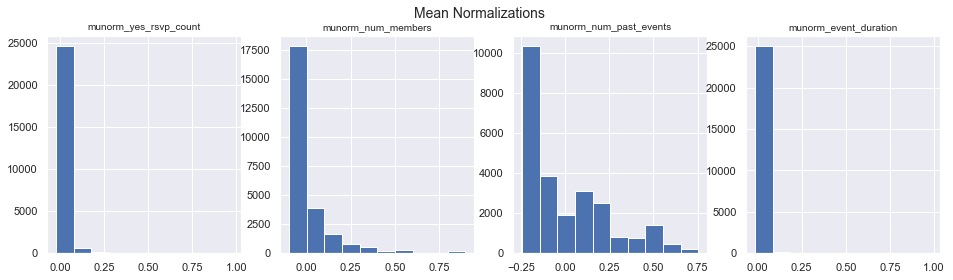

In [158]:
get_hist(df_baseline_w_dummies, 'Mean Normalizations', 
         ['munorm_yes_rsvp_count', 'munorm_num_members', 'munorm_num_past_events', 'munorm_event_duration'],None,
        141)

With a log transformation, ```log_num_members``` and ```log_event_duration``` are now looking more like a normal distribution. ```log_yes_rsvp_count``` and ```log_num_past_events``` are not as normalized.

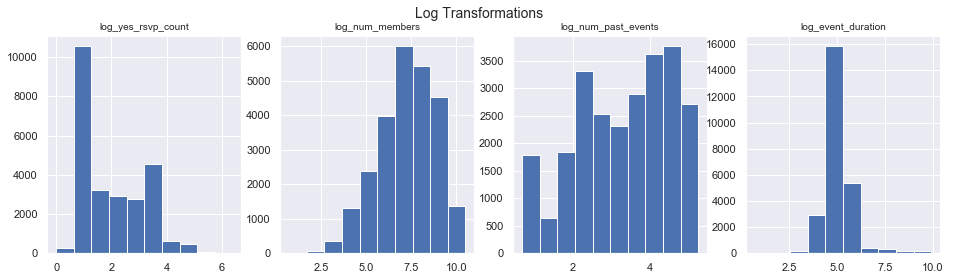

In [159]:
get_hist(df_baseline_w_dummies, 'Log Transformations', 
         ['log_yes_rsvp_count', 'log_num_members', 'log_num_past_events', 'log_event_duration'],None,141)

Tried combining transformation (mean normalization and log transformation) but that did not improve our results (as shown below) so we will go ahead and use the log-transformed values for all of our numerical features.

In [160]:
df_baseline_w_dummies['mulog_yes_rsvp_count'] = df_baseline_w_dummies['log_yes_rsvp_count'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['log_yes_rsvp_count']))
df_baseline_w_dummies['mulog_num_past_events'] = df_baseline_w_dummies['log_num_past_events'].apply(lambda x: mean_normalize(x, df_baseline_w_dummies['log_num_past_events']))


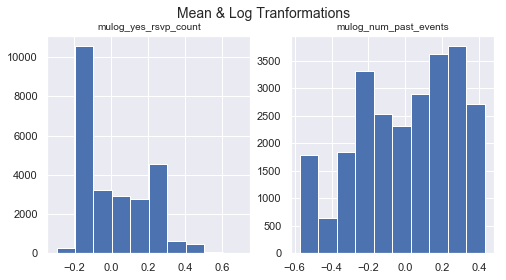

In [161]:
get_hist(df_baseline_w_dummies, 'Mean & Log Tranformations', ['mulog_yes_rsvp_count', 'mulog_num_past_events'],(8,4),121)


In [162]:
df_baseline_w_dummies.columns

Index(['yes_rsvp_count', 'num_members', 'num_past_events', 'event_duration',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing',
       'log_yes_rsvp_count', 'log_num_members', 'log_num_past_events',
       'log_event_duration', 'munorm_yes_rsvp_count', 'munorm_num_members',
       'munorm_num_past_events', 'munorm_event_duration',
       'mulog_yes_rsvp_count', 'mulog_num_past_events'],
      dtype='object')

In [163]:
# creating a final dataframe with the log-transformed and label-encoded values only
df_baseline_final = df_baseline_w_dummies.drop(columns=['yes_rsvp_count','num_members', 'num_past_events', 'event_duration',
                                                       'munorm_yes_rsvp_count', 'munorm_num_members','munorm_num_past_events',
                                                        'munorm_event_duration','mulog_yes_rsvp_count', 'mulog_num_past_events'])



In [164]:
# preview of the new dataframe
df_baseline_final.head()

,book_clubs,career_business,cars_motorcycles,community_environment,dancing,education_learning,fashion_beauty,fitness,food_drink,games,...,singles,socializing,sports_recreation,support,tech,writing,log_yes_rsvp_count,log_num_members,log_num_past_events,log_event_duration
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3.761200,8.993552,3.663562,4.795791
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.174387,8.993552,3.663562,5.017280
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.430817,8.993552,3.663562,5.017280
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,4.736198,8.993552,3.663562,4.795791
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3.091042,8.993552,3.663562,4.795791


In [165]:
df_baseline_final.columns

Index(['book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing',
       'log_yes_rsvp_count', 'log_num_members', 'log_num_past_events',
       'log_event_duration'],
      dtype='object')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Meetup Data: log_yes_rsvp_count~log_num_members
-------------------------------------------------------------------------------------


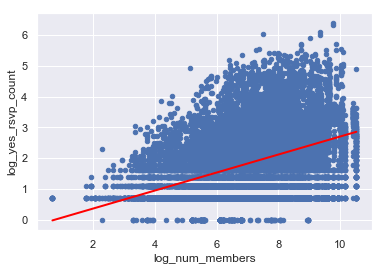

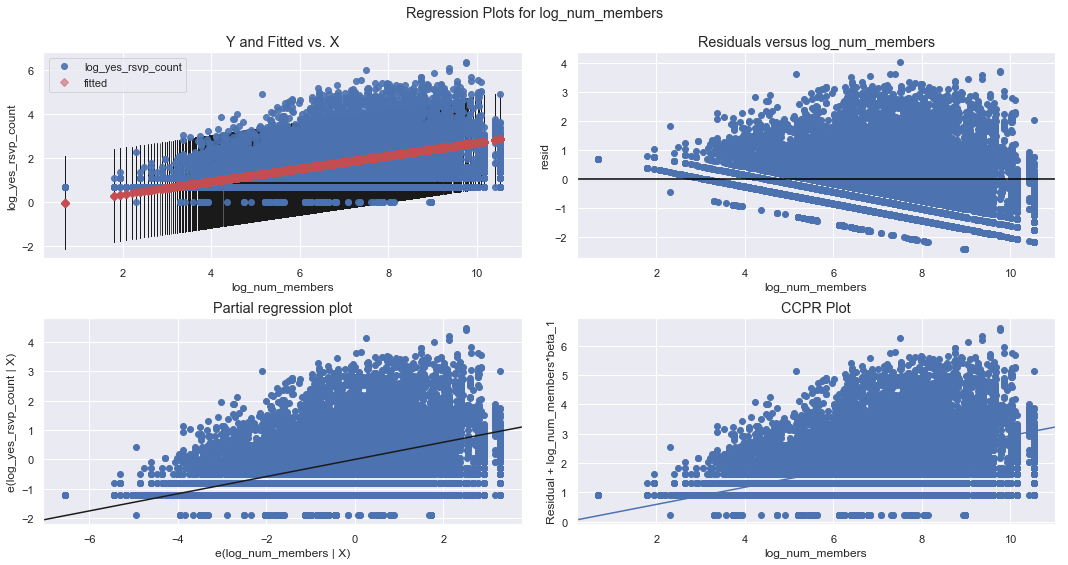

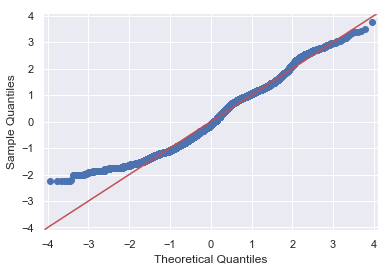

Press Enter to continue...


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Meetup Data: log_yes_rsvp_count~log_num_past_events
-------------------------------------------------------------------------------------


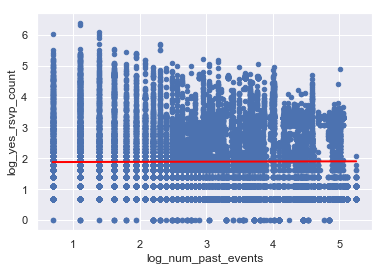

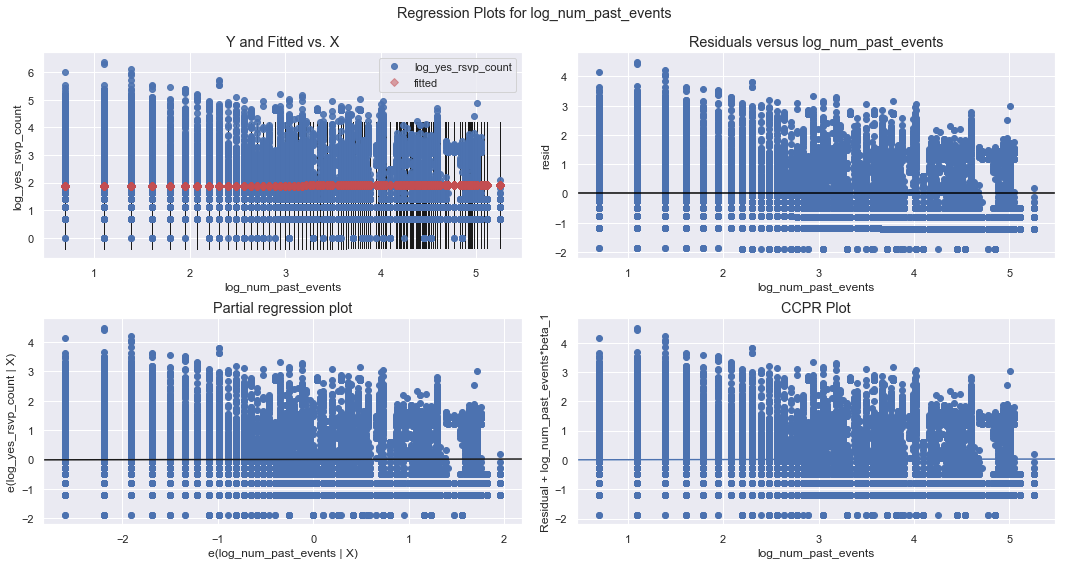

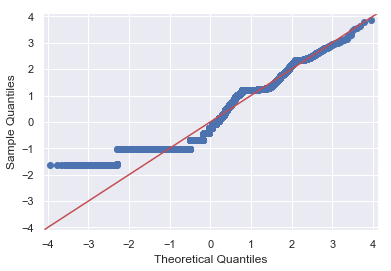

Press Enter to continue...


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Meetup Data: log_yes_rsvp_count~log_event_duration
-------------------------------------------------------------------------------------


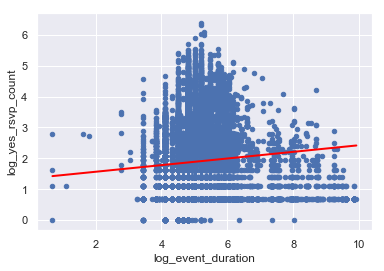

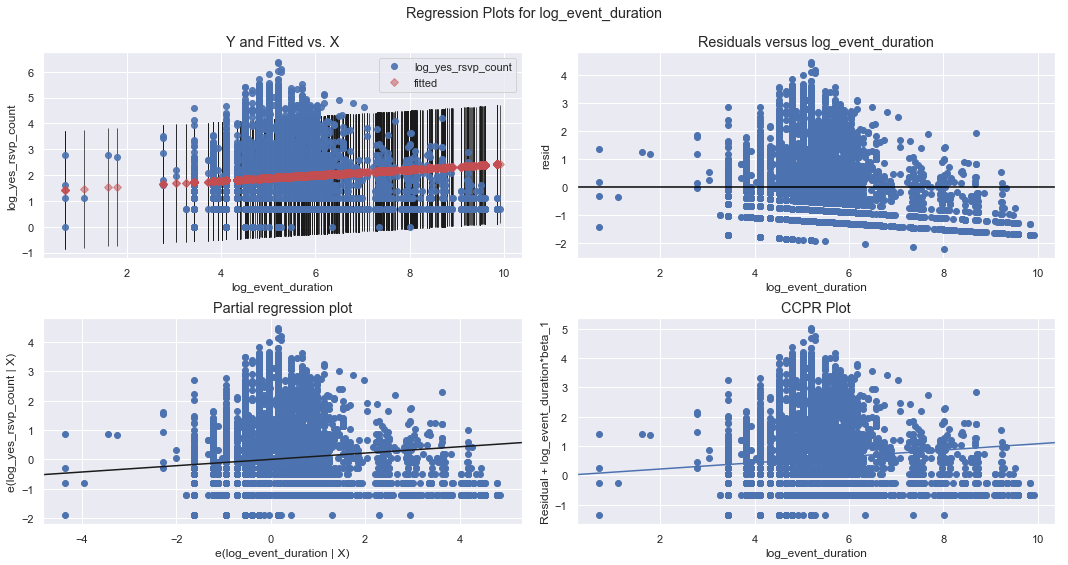

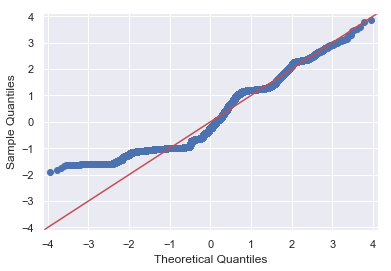

In [166]:
results = get_linear_assumptions_graphs(['log_num_members', 'log_num_past_events', 'log_event_duration'], df_baseline_final)

In [167]:
pd.DataFrame(results, columns = results[0]).drop(index = 0, axis = 0)

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,log_num_members,0.155477,-0.22692,0.292846,0,750.987
2,log_num_past_events,3.1852e-05,1.87542,0.0054295,0.368198,1947.72
3,log_event_duration,0.00486614,1.34951,0.10761,8.39683e-29,1894.76


In [168]:
X_baseline = df_baseline_final.drop(columns ='log_yes_rsvp_count')
y_baseline = df_baseline_final['log_yes_rsvp_count']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_baseline, y_baseline, test_size = 0.2, random_state = 328)


In [169]:
print(f"Number of rows in test set: {len(Xb_test)}")

Number of rows in test set: 5085


In [170]:
print(f"Number of rows in train set: {len(Xb_train)}")

Number of rows in train set: 20339


The results of the train and test sets are below. The $R^2$ values are very close to 0 indicating that the model is not doing well to explain the variance of the independent variables. The low $R^2$ is not surprising since our graphs above demonstrated that the linear model assumptions were not being met by the data, and therefore a linar model would not be a good choice.

$R^2$ values:<br>
- Train = 0.189<br>
- Test = 0.194

Interestingly, the model fit the test set a little better than the train set so we know that with this baseline model, there was no overfitting.

$p$-value of independent variables in both the train and test models are less than 0.05 meaning we can reject the null hypothesis and confirm that there is some relationship between the dependent and independent variables.

In [171]:
Xb_train.columns

Index(['book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing',
       'log_num_members', 'log_num_past_events', 'log_event_duration'],
      dtype='object')

In [172]:
train_set = pd.concat([Xb_train, yb_train], axis =1)

In [173]:
# TRAIN
baseline_train = smf.ols(formula='log_yes_rsvp_count ~ log_num_members + log_num_past_events + log_event_duration', data=train_set).fit()
print(baseline_train.params)
baseline_train.summary()

Intercept             -0.023517
log_num_members        0.385637
log_num_past_events   -0.243274
log_event_duration    -0.015412
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_yes_rsvp_count   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     1717.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:09:15   Log-Likelihood:                -29703.
No. Observations:               20339   AIC:                         5.941e+04
Df Residuals:                   20335   BIC:                         5.945e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0235      0.056     -0.420      0.674      -0.133       0.086
log_num_members         0.3856      0.005     70.828      0.000       0.375       0.396
log_num_past_events    -0.2433      0.007    -35.051      0.000      -0.257      -0.230
log_event_duration     -0.0154      0.010     -1.571      0.116      -0.035       0.004
==============================================================================
Omnibus:                     1221.965   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              678.237
Skew:                           0.295   Prob(JB):                    5.28e-148
Kurtosis:                       2.328   Cond. No.                         74.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# TEST
test_set = pd.concat([Xb_test, yb_test], axis =1)
test_pred = baseline_train.predict(test_set) 
baseline_test_r2 = r2_score(yb_test, test_pred)
print(f"R-squared value of the baseline test set = {baseline_test_r2}")

R-squared value of the baseline test set = 0.20882365337313857


In [302]:
# root-mean-square-error on the test data
# RMSE is the standard deviation of the residuals (or prediction errors). 
# RMSE is a measure of how spread out residuals are (i.e. how concentrated data is around the line of best fit)

rmse_baseline = sqrt(mean_squared_error(np.exp(yb_test)-1, np.exp(test_pred)-1))
print(f"RMSE = {round(rmse_baseline)}")

RMSE = 21


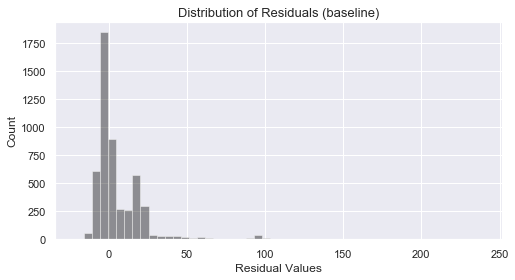

In [303]:
# plot of the residual distribution
baseline_residuals = (np.exp(yb_test)-1) - (np.exp(test_pred)-1)
get_residual_plot(baseline_residuals, None, "Distribution of Residuals (baseline)")

***
#### Model with engineered features
We'll now run the regression again adding our engineered features to the baseline model:

<p style='text-align: left;'>Dependent</p>      |<p style='text-align: left;'>Independent - numerical</p>|<p style='text-align: center;'>Independent - categorical</p>
:------------- |:---------------------------------------------- |:------------------------- 
<p style='text-align: left;'>number of yes rsvps</p> |<p style='text-align: left;'>number of members in group hosting event</p>        |<p style='text-align: left;'>day of week of the event</p>
               |<p style='text-align: left;'>number of past events</p>                           |<p style='text-align: left;'>group category</p>
               |<p style='text-align: left;'>number of words in event description</p>            |<p style='text-align: left;'>fee or no fee event</p>
               |<p style='text-align: left;'>number of subway stations <0.5 miles from venue</p> |
               |<p style='text-align: left;'>number of years the group has been around</p>       |
               |<p style='text-align: left;'>duration of the event</p>                           |
               |<p style='text-align: left;'>timestamp of the event</p>                          |


In [177]:
df_regression = pd.read_pickle('df_sepoct_events_groups_merged_cleaned.pickle')
df_regression.head()

,event_created,event_description,event_duration,event_url,fee,group,event_headcount,how_to_find_us,event_id,maybe_rsvp_count,...,group_state,group_status,group_urlname,group_visibility,group_who,group_category,group_organizer_id,group_yrs_est,group_created_date,num_past_events
0,1535391367000,Join us in person or tune in online! Livestrea...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor/ stream online at ...,254149786,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
1,1535385547000,Get started now on challenges related to these...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,https://zoom.us/j/417883916,254146381,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
2,1535392484000,In this workshop we’ll get a clear sense of th...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor / Livestream at ht...,254150230,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
3,1531947994000,The number of opportunities for software engin...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to the 2nd floor,252915161,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
4,1535383458000,Please tune into the stream here: https://zoom...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please tune into the stream here: https://zoom...,254144933,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38


In [178]:
df_regression.columns

Index(['event_created', 'event_description', 'event_duration', 'event_url',
       'fee', 'group', 'event_headcount', 'how_to_find_us', 'event_id',
       'maybe_rsvp_count', 'event_name', 'photo_url', 'event_rating',
       'rsvp_limit', 'event_status', 'event_time', 'event_updated',
       'utc_offset', 'event_visibility', 'waitlist_count', 'why',
       'yes_rsvp_count', 'group_is_open', 'group_id', 'has_how_to_find',
       'has_rsvp_limit', 'event_num_words', 'has_photo', 'venue_latlon',
       'time_datetime', 'time_m_d_y', 'day_of_week', 'event_hour',
       'event_hour_group', 'subway_distances', 'num_close_subways',
       'has_event_fee', 'created_to_event_days', 'group_created',
       'group_description', 'group_join_mode', 'group_lat', 'group_link',
       'localized_country_name', 'localized_location', 'group_lon',
       'num_members', 'group_name', 'group_state', 'group_status',
       'group_urlname', 'group_visibility', 'group_who', 'group_category',
       'group_org

In [179]:
engineered_cats = ['yes_rsvp_count', 'group_is_open', 'has_how_to_find','event_duration'
                   'has_rsvp_limit', 'event_num_words', 'has_photo', 'day_of_week','event_hour_group',
                   'num_close_subways','has_event_fee', 'created_to_event_days', 
                    'num_members','group_category','group_yrs_est','num_past_events']

In [180]:
len(engineered_cats)

15

In [181]:
# create dataframe for the updated model
df_engineered = df_regression[['yes_rsvp_count', 'group_is_open', 'has_how_to_find','event_duration',
                   'has_rsvp_limit', 'event_num_words', 'has_photo', 'day_of_week','event_hour_group',
                   'num_close_subways','has_event_fee', 'created_to_event_days', 
                    'num_members','group_category','group_yrs_est','num_past_events']]

In [182]:
# log-transformed features to concat to df_engineered
df_logs = df_baseline_w_dummies[['log_yes_rsvp_count','log_num_members','log_num_past_events', 'log_event_duration']]


In [183]:
# additional numerical variables to log-transform
df_logs['log_event_words'] = df_engineered['event_num_words'].apply(lambda x: np.log(x+1))
df_logs['log_yrs_est'] = df_engineered['group_yrs_est'].apply(lambda x: np.log(x+1))
df_logs['log_num_subways'] = df_engineered['num_close_subways'].apply(lambda x: np.log(x+1))
df_logs['log_created_to_event_days'] = df_engineered['created_to_event_days'].apply(lambda x: np.log(x+1))

In [184]:
# dummified group_category to concat to df_engineered
group_category_dummies.head()

,book_clubs,career_business,cars_motorcycles,community_environment,dancing,education_learning,fashion_beauty,fitness,food_drink,games,...,pets_animals,photography,religion_beliefs,sci_fi_fantasy,singles,socializing,sports_recreation,support,tech,writing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [185]:
# label encode day_of_week and event_hour_group
df_engineered['day_of_week'] = df_engineered['day_of_week'].astype('category').cat.codes
df_engineered['event_hour_group'] = df_engineered['event_hour_group'].astype('category').cat.codes

In [405]:
df_regression['event_hour_group'][47]

Interval(8, 12, closed='left')

In [404]:
# merge the dataframes
df_engineered_full = pd.concat([df_engineered, df_logs, group_category_dummies], axis = 1)
df_engineered_full['event_hour_group'][47]

2

In [187]:
df_engineered_full.columns

Index(['yes_rsvp_count', 'group_is_open', 'has_how_to_find', 'event_duration',
       'has_rsvp_limit', 'event_num_words', 'has_photo', 'day_of_week',
       'event_hour_group', 'num_close_subways', 'has_event_fee',
       'created_to_event_days', 'num_members', 'group_category',
       'group_yrs_est', 'num_past_events', 'log_yes_rsvp_count',
       'log_num_members', 'log_num_past_events', 'log_event_duration',
       'log_event_words', 'log_yrs_est', 'log_num_subways',
       'log_created_to_event_days', 'book_clubs', 'career_business',
       'cars_motorcycles', 'community_environment', 'dancing',
       'education_learning', 'fashion_beauty', 'fitness', 'food_drink',
       'games', 'government_politics', 'health_wellbeing', 'hobbies_crafts',
       'language', 'lgbt', 'lifestyle', 'movies_film', 'music',
       'new_age_spirituality', 'outdoors_adventure', 'paranormal',
       'parents_family', 'pets_animals', 'photography', 'religion_beliefs',
       'sci_fi_fantasy', 'singles',

In [188]:
# drop original numerical variable columns
df_engineered_full=df_engineered_full.drop(columns=['num_close_subways', 'event_num_words','group_yrs_est', 
                                         'event_duration','num_members', 'num_past_events','yes_rsvp_count',
                                         'created_to_event_days','group_category'])

In [189]:
df_engineered_full.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee',
       'log_yes_rsvp_count', 'log_num_members', 'log_num_past_events',
       'log_event_duration', 'log_event_words', 'log_yrs_est',
       'log_num_subways', 'log_created_to_event_days', 'book_clubs',
       'career_business', 'cars_motorcycles', 'community_environment',
       'dancing', 'education_learning', 'fashion_beauty', 'fitness',
       'food_drink', 'games', 'government_politics', 'health_wellbeing',
       'hobbies_crafts', 'language', 'lgbt', 'lifestyle', 'movies_film',
       'music', 'new_age_spirituality', 'outdoors_adventure', 'paranormal',
       'parents_family', 'pets_animals', 'photography', 'religion_beliefs',
       'sci_fi_fantasy', 'singles', 'socializing', 'sports_recreation',
       'support', 'tech', 'writing'],
      dtype='object')

In [190]:
df_engineered_full.drop(columns = ['log_yes_rsvp_count']).to_pickle('df_X.pickle')
df_engineered_full['log_yes_rsvp_count'].to_pickle('df_y.pickle')

In [191]:
# dataframe with raw values for numerical variables
df_engineered_numerical = df_engineered[['num_close_subways', 'event_num_words','group_yrs_est', 
                                         'event_duration','num_members', 'num_past_events','yes_rsvp_count',
                                         'created_to_event_days','day_of_week']]

<i>Multicollinearity</i>

According to the correlation heatmap below, there is no multicollinearity among the numerical variables.

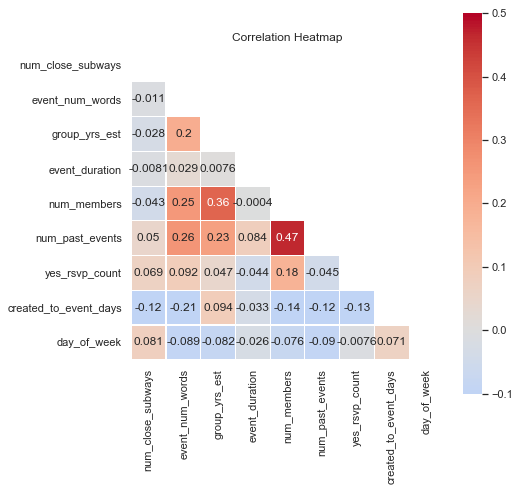

In [192]:
get_corr_heatmap(df_engineered_numerical,figsize = (7,7))

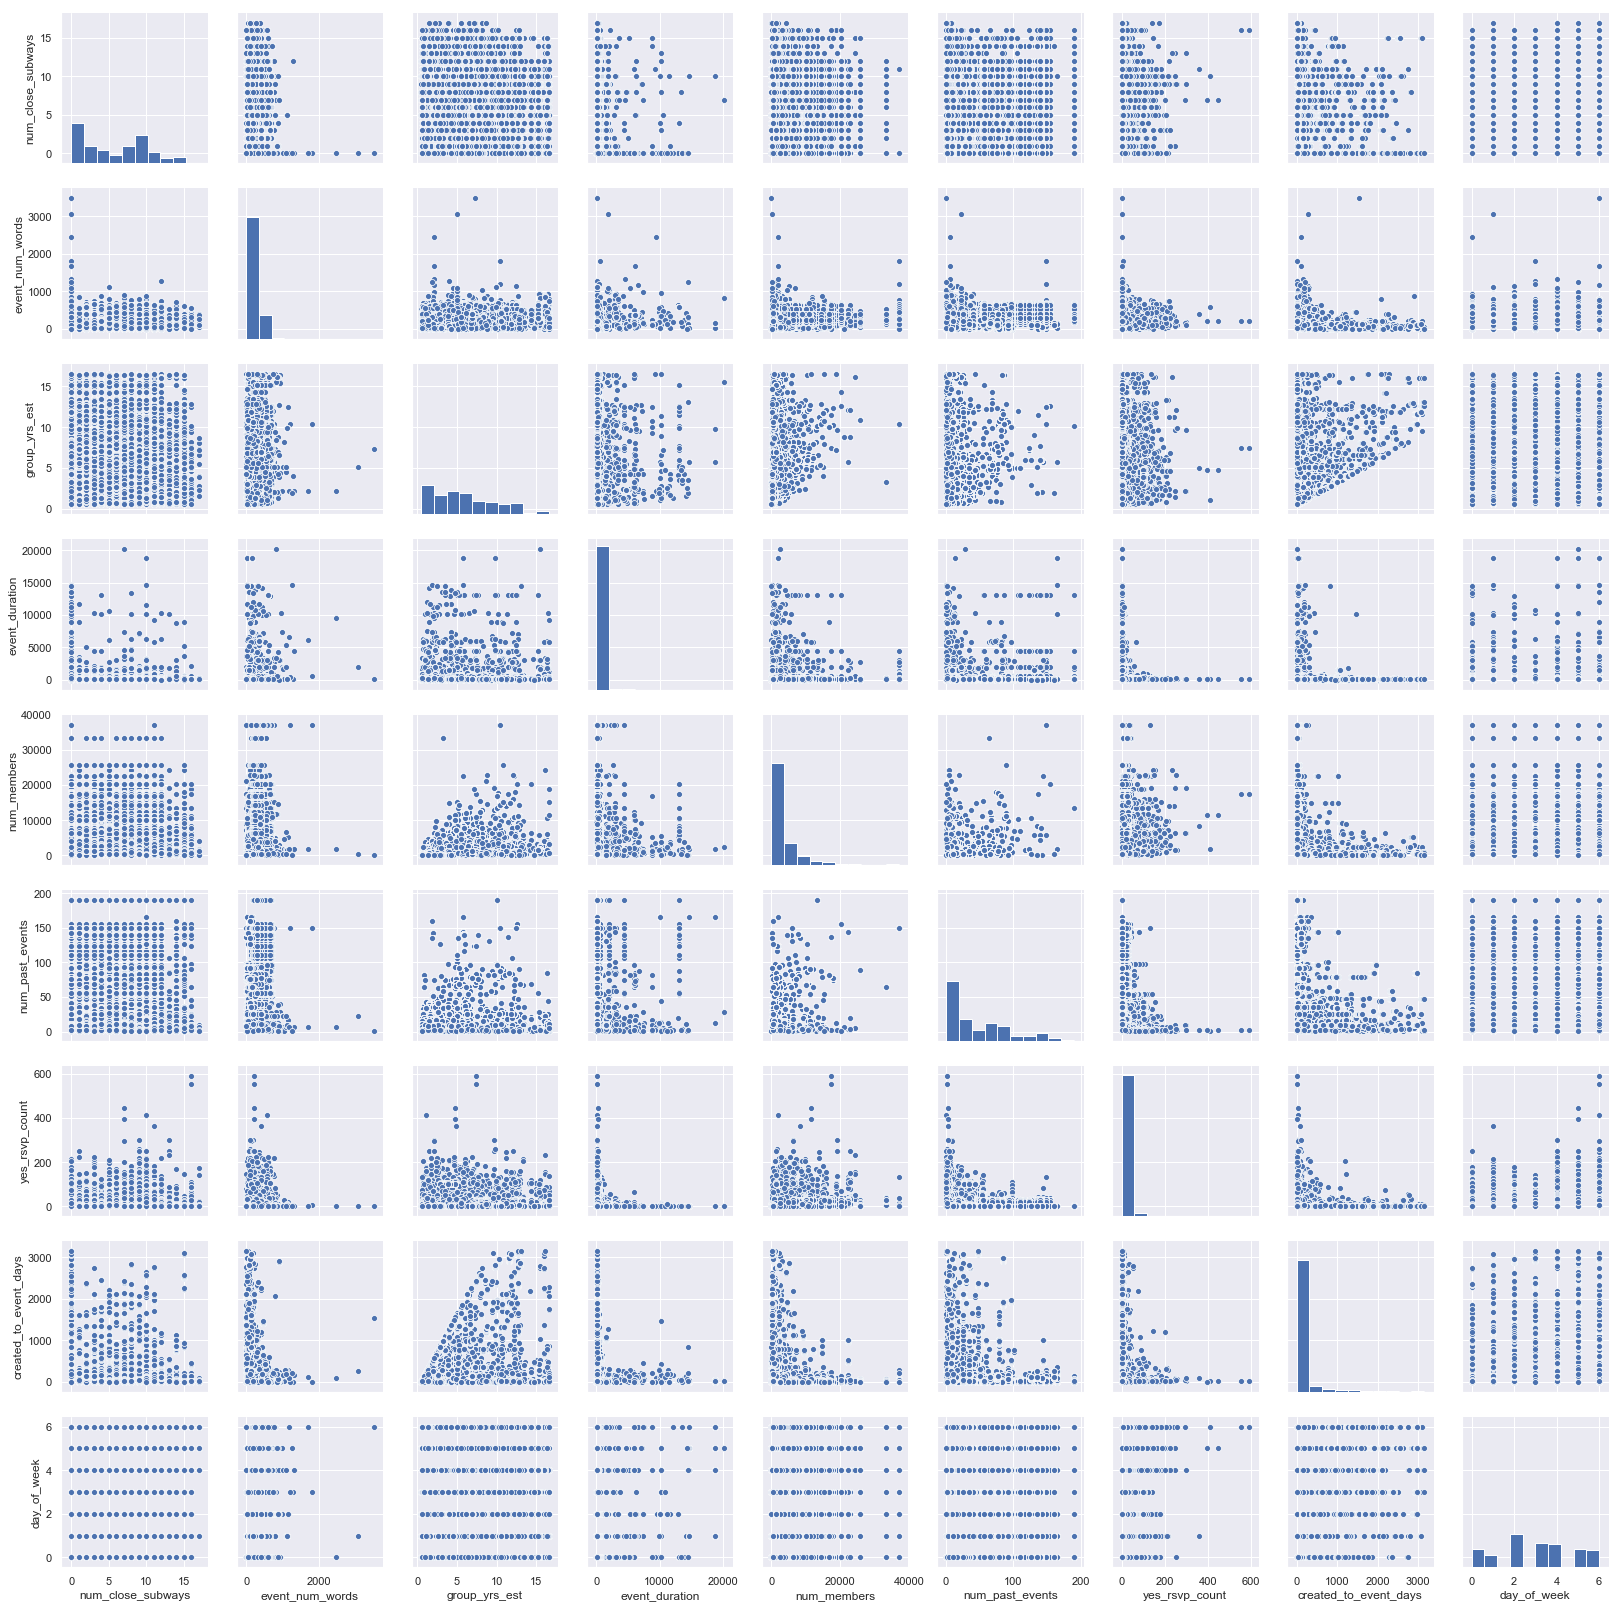

In [193]:
sns.pairplot(df_engineered_numerical, diag_kind= 'hist')

Let's take a closer look at the distribution of the new numerical variables ```num_close_subways```, ```event_description_num_words```, and ```group_yrs_est```. They do not look normally distributed so we will have to conduct some transformations to see if that may smooth them into a normal distribution.

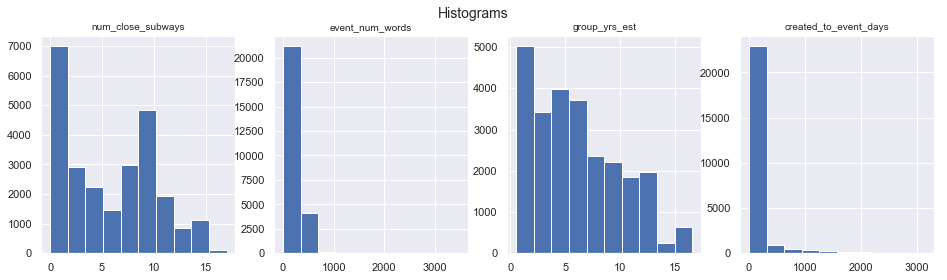

In [194]:
get_hist(df_engineered_numerical, 'Histograms', ['num_close_subways', 'event_num_words', 'group_yrs_est','created_to_event_days'],
        None, 141)

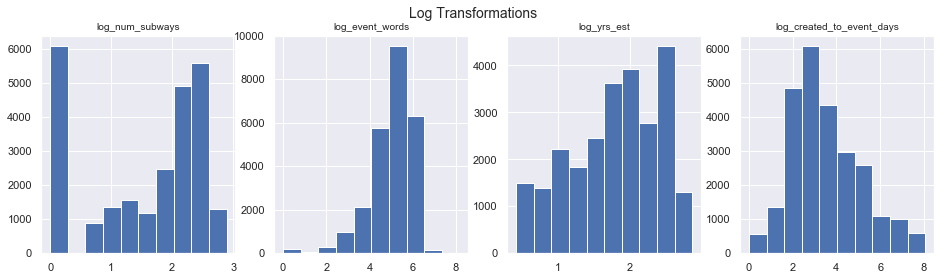

In [195]:
get_hist(df_engineered_full, 'Log Transformations', ['log_num_subways', 'log_event_words', 'log_yrs_est', 'log_created_to_event_days'],
        None, 141)

The log-transformations of ```log_event_words```,  ```log_yrs_est``` and ```log_created_to_event_days``` look more normal so we will keep those values for the regression. The ```log_num_subways``` does not look normal. We could try to the mean normalization on it as well but from earlier example, the mean normlalization will return the same shape as the log or original data, whichever one the transformation is applied to. 

<i> Checking for interactions </i>

Below we run some analysis to see if there are any interactions between variables. An interaction occurs when two or more variables interact in a non-additive manner when affecting a third variable, meaning when two variables interact they have an effect that is more (or less) than the sum of their parts. Interactions are important because if they exist and are accounted for, it can improve the $R^2$ of the model.

We ran a pairplot and set hue to ```day_of_week``` and look at how the regression and scatter plot looks like across each independent-dependent variable pairs.

From the graphs, it seems there is interaction with ```event_num_words```, ```num_members``` and ```event_duration``` as the slopes of the regression lines appear to intersect.

In [196]:
df_engineered_numerical.columns

Index(['num_close_subways', 'event_num_words', 'group_yrs_est',
       'event_duration', 'num_members', 'num_past_events', 'yes_rsvp_count',
       'created_to_event_days', 'day_of_week'],
      dtype='object')

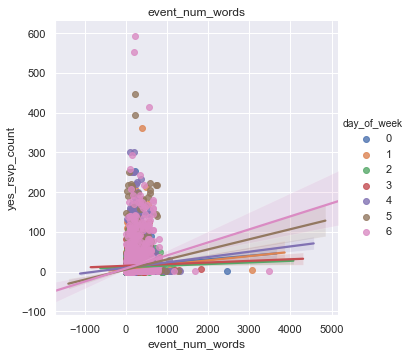

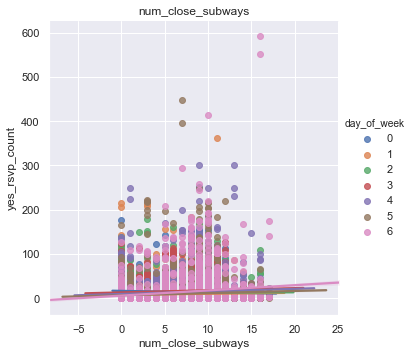

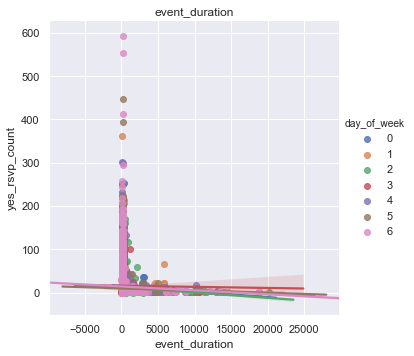

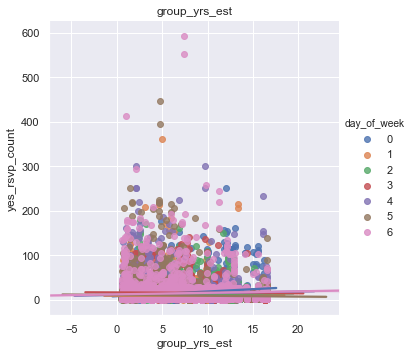

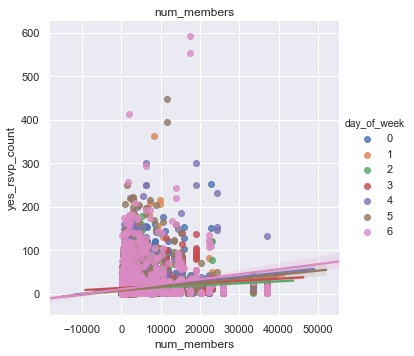

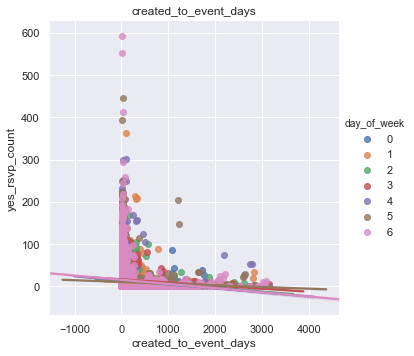

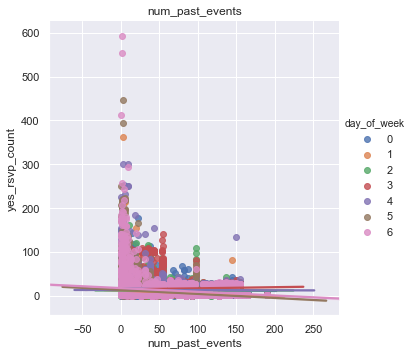

In [197]:
for i, x in enumerate(['event_num_words', 'num_close_subways', 'event_duration', 'group_yrs_est', 'num_members',
                      'created_to_event_days', 'num_past_events']):
    sns.lmplot(x=x, y="yes_rsvp_count", hue="day_of_week", data=df_engineered_numerical)
    plt.title(x)

In [198]:
df_engineered_full.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee',
       'log_yes_rsvp_count', 'log_num_members', 'log_num_past_events',
       'log_event_duration', 'log_event_words', 'log_yrs_est',
       'log_num_subways', 'log_created_to_event_days', 'book_clubs',
       'career_business', 'cars_motorcycles', 'community_environment',
       'dancing', 'education_learning', 'fashion_beauty', 'fitness',
       'food_drink', 'games', 'government_politics', 'health_wellbeing',
       'hobbies_crafts', 'language', 'lgbt', 'lifestyle', 'movies_film',
       'music', 'new_age_spirituality', 'outdoors_adventure', 'paranormal',
       'parents_family', 'pets_animals', 'photography', 'religion_beliefs',
       'sci_fi_fantasy', 'singles', 'socializing', 'sports_recreation',
       'support', 'tech', 'writing'],
      dtype='object')

In [199]:
# train, test, split
Xe = df_engineered_full.drop(columns ='log_yes_rsvp_count')
ye = df_engineered_full['log_yes_rsvp_count']

Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size = 0.2, random_state = 328)

In [200]:
# create dataframe of the train and test sets 
trainset_e = pd.concat([Xe_train, ye_train], axis = 1)
testset_e = pd.concat([Xe_test, ye_test], axis = 1)

Let's look at the regression with full set of engineered features but no interactions just yet.

In [201]:
Xe_train.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [202]:
# TRAIN
# get string format of the regression formula that includes all columns
formula_1 = 'log_yes_rsvp_count~' + '+'.join([v for v in Xe_train.columns])
    
train_reg = smf.ols(formula=formula_1, data=trainset_e).fit()
print(train_reg.params)
train_reg.summary()

Intercept                    0.428302
group_is_open               -0.237354
has_how_to_find              0.058084
has_rsvp_limit               0.003237
has_photo                    0.094639
day_of_week                 -0.005016
event_hour_group             0.023165
has_event_fee               -0.618214
log_num_members              0.350466
log_num_past_events         -0.258097
log_event_duration          -0.066542
log_event_words              0.094218
log_yrs_est                 -0.227245
log_num_subways              0.024397
log_created_to_event_days   -0.026938
book_clubs                   0.303616
career_business              0.150761
cars_motorcycles             0.072500
community_environment       -0.075048
dancing                     -0.120744
education_learning           0.289399
fashion_beauty               0.707882
fitness                      0.057649
food_drink                  -0.057517
games                        0.125071
government_politics         -0.003141
health_wellb

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_yes_rsvp_count   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     223.9
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:15:31   Log-Likelihood:                -27826.
No. Observations:               20339   AIC:                         5.575e+04
Df Residuals:                   20292   BIC:                         5.612e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.4283      0.093      4.588      0.000       0.245       0.611
group_is_open                -0.2374      0.027     -8.793      0.000      -0.290      -0.184
has_how_to_find               0.0581      0.015      3.834      0.000       0.028       0.088
has_rsvp_limit                0.0032      0.017      0.188      0.851      -0.031       0.037
has_photo                     0.0946      0.015      6.167      0.000       0.065       0.125
day_of_week                  -0.0050      0.004     -1.332      0.183      -0.012       0.002
event_hour_group              0.0232      0.004      5.554      0.000       0.015       0.031
has_event_fee                -0.6182      0.020    -30.882      0.000      -0.657      -0.579
log_num_members               0.3505      0.007     50.186      0.000       0.337       0.364
log_num_past_events          -0.2581      0.007    -35.189      0.000      -0.272      -0.244
log_event_duration           -0.0665      0.010     -6.950      0.000      -0.085      -0.048
log_event_words               0.0942      0.008     11.472      0.000       0.078       0.110
log_yrs_est                  -0.2272      0.015    -15.549      0.000      -0.256      -0.199
log_num_subways               0.0244      0.007      3.399      0.001       0.010       0.038
log_created_to_event_days    -0.0269      0.005     -5.367      0.000      -0.037      -0.017
book_clubs                    0.3036      0.135      2.244      0.025       0.038       0.569
career_business               0.1508      0.054      2.776      0.006       0.044       0.257
cars_motorcycles              0.0725      0.178      0.408      0.683      -0.276       0.421
community_environment        -0.0750      0.080     -0.936      0.349      -0.232       0.082
dancing                      -0.1207      0.060     -2.012      0.044      -0.238      -0.003
education_learning            0.2894      0.068      4.250      0.000       0.156       0.423
fashion_beauty                0.7079      0.079      9.012      0.000       0.554       0.862
fitness                       0.0576      0.060      0.958      0.338      -0.060       0.176
food_drink                   -0.0575      0.069     -0.838      0.402      -0.192       0.077
games                         0.1251      0.069      1.816      0.069      -0.010       0.260
government_politics          -0.0031      0.088     -0.036      0.972      -0.176       0.170
health_wellbeing             -0.1138      0.055     -2.056      0.040      -0.222      -0.005
hobbies_crafts                0.1242      0.106      1.166      0.243      -0.084       0.333
language                      0.0420      0.055      0.763      0.445      -0.066       0.150
lgbt                          0.2525      0.087      2.897      0.004      

In [203]:
# R-squared value of test set
reg_pred = train_reg.predict(Xe_test) 
reg_r2 = r2_score(ye_test, reg_pred)
print(f"R-squared value of test set = {reg_r2}")

R-squared value of test set = 0.3423990770730466


Now let's see what our $R^2$ value is with the interaction element added in between ```day_of_week``` and ```event_num_words```, ```num_members``` and ```event_duration```.

In [204]:
# set the formula and train linear regression model
formula_1 = 'log_yes_rsvp_count~' + '+'.join([v for v in Xe_train.columns])
formula_1

'log_yes_rsvp_count~group_is_open+has_how_to_find+has_rsvp_limit+has_photo+day_of_week+event_hour_group+has_event_fee+log_num_members+log_num_past_events+log_event_duration+log_event_words+log_yrs_est+log_num_subways+log_created_to_event_days+book_clubs+career_business+cars_motorcycles+community_environment+dancing+education_learning+fashion_beauty+fitness+food_drink+games+government_politics+health_wellbeing+hobbies_crafts+language+lgbt+lifestyle+movies_film+music+new_age_spirituality+outdoors_adventure+paranormal+parents_family+pets_animals+photography+religion_beliefs+sci_fi_fantasy+singles+socializing+sports_recreation+support+tech+writing'

In [205]:
# engineered features w/ interactions between (day_of_week & log_event_words) and (day_of_week & log_num_subways)
formula_int = 'log_yes_rsvp_count~group_is_open+has_how_to_find+has_rsvp_limit+has_photo+day_of_week+event_hour_group+has_event_fee+log_num_members*day_of_week+log_num_past_events+log_event_duration*day_of_week+log_event_words*day_of_week+log_yrs_est+log_num_subways+log_created_to_event_days+book_clubs+career_business+cars_motorcycles+community_environment+dancing+education_learning+fashion_beauty+fitness+food_drink+games+government_politics+health_wellbeing+hobbies_crafts+language+lgbt+lifestyle+movies_film+music+new_age_spirituality+outdoors_adventure+paranormal+parents_family+pets_animals+photography+religion_beliefs+sci_fi_fantasy+singles+socializing+sports_recreation+support+tech+writing'
train_int = smf.ols(formula=formula_int, data=trainset_e).fit()
print(train_int.params)
train_int.summary()

Intercept                         0.360479
group_is_open                    -0.237508
has_how_to_find                   0.058331
has_rsvp_limit                    0.002634
has_photo                         0.095194
day_of_week                       0.014725
event_hour_group                  0.022937
has_event_fee                    -0.617818
log_num_members                   0.359532
log_num_members:day_of_week      -0.002870
log_num_past_events              -0.258669
log_event_duration               -0.077686
log_event_duration:day_of_week    0.003687
log_event_words                   0.105805
log_event_words:day_of_week      -0.003575
log_yrs_est                      -0.226975
log_num_subways                   0.025249
log_created_to_event_days        -0.026972
book_clubs                        0.307974
career_business                   0.150993
cars_motorcycles                  0.071254
community_environment            -0.074057
dancing                          -0.118495
education_l

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_yes_rsvp_count   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     210.2
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:24:58   Log-Likelihood:                -27824.
No. Observations:               20339   AIC:                         5.575e+04
Df Residuals:                   20289   BIC:                         5.614e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3605      0.125      2.885      0.004       0.116       0.605
group_is_open                     -0.2375      0.027     -8.793      0.000      -0.290      -0.185
has_how_to_find                    0.0583      0.015      3.847      0.000       0.029       0.088
has_rsvp_limit                     0.0026      0.017      0.153      0.879      -0.031       0.036
has_photo                          0.0952      0.015      6.202      0.000       0.065       0.125
day_of_week                        0.0147      0.029      0.504      0.614      -0.043       0.072
event_hour_group                   0.0229      0.004      5.496      0.000       0.015       0.031
has_event_fee                     -0.6178      0.020    -30.839      0.000      -0.657      -0.579
log_num_members                    0.3595      0.011     34.128      0.000       0.339       0.380
log_num_members:day_of_week       -0.0029      0.003     -1.122      0.262      -0.008       0.002
log_num_past_events               -0.2587      0.007    -35.226      0.000      -0.273      -0.244
log_event_duration                -0.0777      0.016     -4.733      0.000      -0.110      -0.046
log_event_duration:day_of_week     0.0037      0.005      0.775      0.438      -0.006       0.013
log_event_words                    0.1058      0.015      6.904      0.000       0.076       0.136
log_event_words:day_of_week       -0.0036      0.004     -0.866      0.386      -0.012       0.005
log_yrs_est                       -0.2270      0.015    -15.527      0.000      -0.256      -0.198
log_num_subways                    0.0252      0.007      3.509      0.000       0.011       0.039
log_created_to_event_days         -0.0270      0.005     -5.367      0.000      -0.037      -0.017
book_clubs                         0.3080      0.135      2.275      0.023       0.043       0.573
career_business                    0.1510      0.054      2.779      0.005       0.045       0.257
cars_motorcycles                   0.0713      0.178      0.401      0.688      -0.277       0.419
community_environment             -0.0741      0.080     -0.924      0.356      -0.231       0.083
dancing                           -0.1185      0.060     -1.974      0.048      -0.236      -0.001
education_learning                 0.2913      0.068      4.275      0.000       0.158       0.425
fashion_beauty                     0.7067      0.079      8.996      0.000       0.553       0.861
fitness                            0.0600      0.060      0.995      0.320      -0.058       0.178
food_drink                        -0.0577      0.069     -0.840      0.401      -0.192       0.077
games                              0.1287      0.069      1.868      0.062      -0.006       0.264
government_pol

In [206]:
# R-squared value of test set
reg_pred_int = train_int.predict(Xe_test) 
testint_r2 = r2_score(ye_test, reg_pred_int)
print(f"R-squared value of the baseline test set = {testint_r2}")

R-squared value of the baseline test set = 0.3421301013630548


In [304]:
#root-mean-square-error on the test data
rmse_lr = sqrt(mean_squared_error(np.exp(ye_test)-1, np.exp(reg_pred_int)-1))
rmse_lr

19.99849724676349

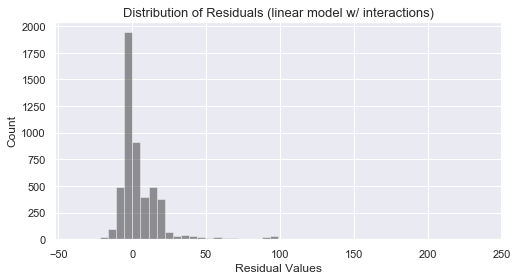

In [305]:
# plot of the residual distribution
lr_residuals = (np.exp(ye_test)-1) - (np.exp(reg_pred_int)-1)
get_residual_plot(lr_residuals, None, "Distribution of Residuals (linear model w/ interactions)")

In [69]:
df_engineered_full.to_pickle("df_engineered_full.pickle")

***
<a id='reg'></a>

## 2. Regularization Regressions

When the number of features in a regression model increases, the chances of the model overfitting increases as a result. In order to counteract the possibility of overfitting, we can implement regularization methods to the model that will effectively penalize the model by reducing and in some cases zeroing the coefficients of certain independent variable to reduce or eliminate their effect on the outcome.

We will try two types of regularization techniques - ridge (L2) and lasso (L1).

We will dummify the ```group_category``` and ```day_of_week``` columns as we did above but this time keep all columns since we do not need to drop-one-out when using a regularization regression. We will keep the log transformation values of the numerical variables.

<i>Preparing the dataset</i>

In [407]:
Xreg = pd.read_pickle('df_X.pickle')
yreg =pd.read_pickle('df_y.pickle')

In [409]:
Xreg.drop(columns = ['book_clubs','career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'], inplace=True)

In [410]:
group_dummies = pd.get_dummies(df_regression['group_category'])

In [411]:
Xreg = pd.concat([Xreg, group_dummies], axis=1)

In [412]:
Xreg.head(1)

,group_is_open,has_how_to_find,has_rsvp_limit,has_photo,day_of_week,event_hour_group,has_event_fee,log_num_members,log_num_past_events,log_event_duration,...,pets-animals,photography,religion-beliefs,sci-fi-fantasy,singles,socializing,sports-recreation,support,tech,writing
0,1,1,0,0,5,5,0,8.993552,3.663562,4.795791,...,0,0,0,0,0,0,0,0,1,0


#### Ridge Regression (L2 Norm)

In [417]:
# train, test, pslit
X_train, X_test, y_train, y_test = train_test_split(Xreg, yreg, test_size = 0.2, random_state = 328)

In [414]:
# create and fit the ridge regression to training data
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [415]:
# get R-squared score for train and test set
print(f"R-squared for ridge train set: {ridge.score(X_train, y_train)}")
print(f"R-squared for ridge test set: {ridge.score(X_test, y_test)}")

R-squared for ridge train set: 0.33663711294758236
R-squared for ridge test set: 0.34239545263436044


In [307]:
# get RMSE for test set
ridge_preds = ridge.predict(X_test)
ridge_residuals = (np.exp(y_test)-1) - (np.exp(ridge_preds)-1)

print(f"RMSE (test): {sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(ridge_preds)-1))}")

RMSE (test): 19.99047042689671


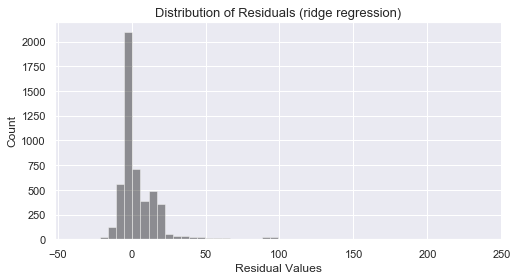

In [308]:
get_residual_plot(ridge_residuals,None,'Distribution of Residuals (ridge regression)')

<i>Hyperparamter Tuning</i>

With the ridge regression, the R-squared value did not change much with different values of alpha.

In [226]:
ridge_results = ridge_alpha([0.5, 0.25, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0001, 0.00001], X_train, X_test, y_train, y_test)

In [227]:
ridge_results

,alpha,test_r2,train_r2
0,0.50000,0.342397,0.336638
1,0.25000,0.342398,0.336638
2,0.05000,0.342399,0.336638
3,0.02000,0.342399,0.336638
4,0.01000,0.342399,0.336638
5,0.00500,0.342399,0.336638
6,0.00200,0.342399,0.336638
7,0.00100,0.342399,0.336638
8,0.00010,0.342399,0.336638
9,0.00001,0.342399,0.336638


In [418]:
ridge_05 = Ridge(alpha=0.05)
ridge_05.fit(X_train, y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [419]:
# make predictions on the test set
ridge_05_preds = ridge_05.predict(X_test)

In [420]:
ridge_05.score(X_test, y_test)

0.3423987515771115

In [310]:
#root-mean-square-error on the test data
rmse_ridge = sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(ridge_05_preds)-1))
rmse_ridge

19.990271949284196

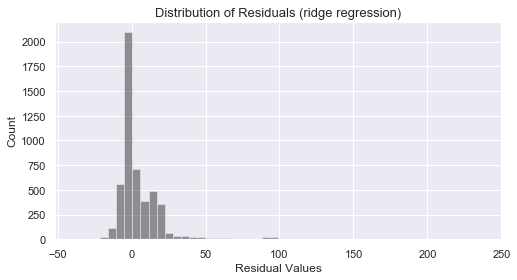

In [311]:
# plot of the residual distribution
ridge_residuals = (np.exp(y_test)-1) - (np.exp(ridge_05_preds)-1)
get_residual_plot(ridge_residuals, None, "Distribution of Residuals (ridge regression)")

#### Lasso Regression (L1 Norm)

In [233]:
# create and fit the lasso regression to training data
lasso = Lasso(alpha = 0.5)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [234]:
# get R-squared score for train and test set
print(f"R-squared for lasso train set: {lasso.score(X_train, y_train)}")
print(f"R-squared for lasso test set: {lasso.score(X_test, y_test)}")

R-squared for lasso train set: 0.07944030734447183
R-squared for lasso test set: 0.08162908669772295


<i>Different alphas</i>

In the lasso regression, a smaller alpha produced a model with a high R-squared. At $alpha$ = 0.2, the test $R^2$ was 0.096 but that increased to 0.30 with $alpha$ = 0.001.

In [235]:
lasso_results = lasso_alpha([0.5, 0.25, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0001, 0.00001], X_train, X_test, y_train, y_test)

In [236]:
lasso_results

,alpha,test_r2,train_r2
0,0.50000,0.081629,0.079440
1,0.25000,0.151549,0.145671
2,0.05000,0.259177,0.248039
3,0.02000,0.306464,0.298368
4,0.01000,0.323268,0.317026
5,0.00500,0.333626,0.327578
6,0.00200,0.339117,0.333133
7,0.00100,0.340879,0.335180
8,0.00010,0.342329,0.336577
9,0.00001,0.342399,0.336637


Text(0.5, 1.0, 'Test R-Squared value w/ changing alpha (lasso)')

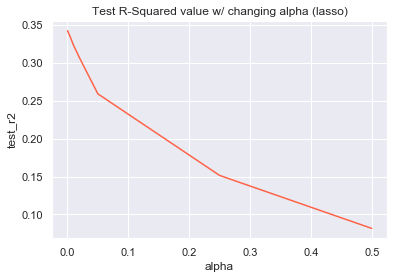

In [237]:
sns.lineplot(x = 'alpha', y = 'test_r2', data = lasso_results, color = 'tomato')
plt.title('Test R-Squared value w/ changing alpha (lasso)')

In [421]:
lasso_001 = Lasso(alpha = 0.001)
lasso_001.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [423]:
lasso_001.score(X_test, y_test)

0.34087813871133954

In [422]:
# make predictions on the test set
lasso_001_preds = lasso_001.predict(X_test)

In [312]:
#root-mean-square-error on the test data
rmse_lasso = sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(lasso_001_preds)-1))
rmse_lasso

20.02255627587214

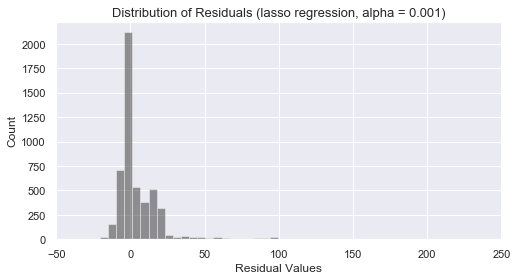

In [313]:
# plot of the residual distribution
lasso_residuals = (np.exp(y_test)-1) - (np.exp(lasso_001_preds)-1)
get_residual_plot(lasso_residuals, None, "Distribution of Residuals (lasso regression, alpha = 0.001)")

***
<a id='support'></a>
## 3. Support Vector Regression

For Support Vector Regression, we will perform a standard scaler on the numerical variables instead of normalizing the data as we did above for the linear regression model. Note that generally for models that are based on distance measurements, it is best to scale the data so that values are all withi certain numerical bound. Note that scaling is different from normalization, which will change the distribution of the data - scaling does not do this.

Results of the log-transformed data is included as well for comparison.

In [248]:
# import the scaler (we will use MinMaxScaler since our variables are not normally distributed)
from sklearn.preprocessing import MinMaxScaler

# read in the original data set
df_svr = pd.read_pickle('df_sepoct_events_groups_merged_cleaned.pickle')
df_svr.head()

,event_created,event_description,event_duration,event_url,fee,group,event_headcount,how_to_find_us,event_id,maybe_rsvp_count,...,group_state,group_status,group_urlname,group_visibility,group_who,group_category,group_organizer_id,group_yrs_est,group_created_date,num_past_events
0,1535391367000,Join us in person or tune in online! Livestrea...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor/ stream online at ...,254149786,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
1,1535385547000,Get started now on challenges related to these...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,https://zoom.us/j/417883916,254146381,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
2,1535392484000,In this workshop we’ll get a clear sense of th...,150.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor / Livestream at ht...,254150230,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
3,1531947994000,The number of opportunities for software engin...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to the 2nd floor,252915161,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38
4,1535383458000,Please tune into the stream here: https://zoom...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please tune into the stream here: https://zoom...,254144933,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38


In [249]:
df_svr.columns

Index(['event_created', 'event_description', 'event_duration', 'event_url',
       'fee', 'group', 'event_headcount', 'how_to_find_us', 'event_id',
       'maybe_rsvp_count', 'event_name', 'photo_url', 'event_rating',
       'rsvp_limit', 'event_status', 'event_time', 'event_updated',
       'utc_offset', 'event_visibility', 'waitlist_count', 'why',
       'yes_rsvp_count', 'group_is_open', 'group_id', 'has_how_to_find',
       'has_rsvp_limit', 'event_num_words', 'has_photo', 'venue_latlon',
       'time_datetime', 'time_m_d_y', 'day_of_week', 'event_hour',
       'event_hour_group', 'subway_distances', 'num_close_subways',
       'has_event_fee', 'created_to_event_days', 'group_created',
       'group_description', 'group_join_mode', 'group_lat', 'group_link',
       'localized_country_name', 'localized_location', 'group_lon',
       'num_members', 'group_name', 'group_state', 'group_status',
       'group_urlname', 'group_visibility', 'group_who', 'group_category',
       'group_org

In [250]:
df_svr = df_svr[['event_duration','yes_rsvp_count', 'group_is_open','has_how_to_find',
       'has_rsvp_limit', 'event_num_words', 'has_photo','day_of_week',
       'event_hour_group', 'num_close_subways','has_event_fee', 'created_to_event_days', 
       'num_members', 'group_category','group_yrs_est', 'num_past_events']]

In [251]:
# pre-scaling
df_svr.head(1)

,event_duration,yes_rsvp_count,group_is_open,has_how_to_find,has_rsvp_limit,event_num_words,has_photo,day_of_week,event_hour_group,num_close_subways,has_event_fee,created_to_event_days,num_members,group_category,group_yrs_est,num_past_events
0,120.0,42,1,1,0,137,0,Tuesday,"[21, 24)",12,0,8.204086,8050,tech,2.276969,38


In [252]:
# you can use scaler.inverse_transform(df_svr['yes_rsvp_count']) to revert the predictions to real values
scaler = MinMaxScaler()
df_svr[['event_duration','yes_rsvp_count', 'event_num_words','num_close_subways','created_to_event_days', 
       'num_members', 'group_yrs_est', 'num_past_events']] = scaler.fit_transform(df_svr[['event_duration','yes_rsvp_count', 'event_num_words','num_close_subways','created_to_event_days', 
       'num_members', 'group_yrs_est', 'num_past_events']])


In [253]:
# post-scaling
df_svr.head(1)

,event_duration,yes_rsvp_count,group_is_open,has_how_to_find,has_rsvp_limit,event_num_words,has_photo,day_of_week,event_hour_group,num_close_subways,has_event_fee,created_to_event_days,num_members,group_category,group_yrs_est,num_past_events
0,0.005903,0.070946,1,1,0,0.039255,0,Tuesday,"[21, 24)",0.705882,0,0.002605,0.21696,tech,0.109954,0.195767


In [254]:
df_svr.dtypes

event_duration            float64
yes_rsvp_count            float64
group_is_open               int64
has_how_to_find             int64
has_rsvp_limit              int64
event_num_words           float64
has_photo                   int64
day_of_week                object
event_hour_group         category
num_close_subways         float64
has_event_fee               int64
created_to_event_days     float64
num_members               float64
group_category             object
group_yrs_est             float64
num_past_events           float64
dtype: object

In [257]:
df_svr['group_category'] = df_svr['group_category'].astype('category')
df_svr['day_of_week'] = df_svr['day_of_week'].astype('category').cat.codes
Xsvr1['event_hour_group'] = Xsvr1.event_hour_group.astype('category').cat.codes

In [258]:
svr_groupdummies = pd.get_dummies(df_svr['group_category'], drop_first = True)

In [259]:
df_svr = pd.concat([df_svr, svr_groupdummies], axis =1)
df_svr.head(1)

,event_duration,yes_rsvp_count,group_is_open,has_how_to_find,has_rsvp_limit,event_num_words,has_photo,day_of_week,event_hour_group,num_close_subways,...,pets-animals,photography,religion-beliefs,sci-fi-fantasy,singles,socializing,sports-recreation,support,tech,writing
0,0.005903,0.070946,1,1,0,0.039255,0,5,"[21, 24)",0.705882,...,0,0,0,0,0,0,0,0,1,0


In [260]:
df_svr.drop(columns=['group_category'], inplace = True)

In [266]:
Xsvr1 = df_svr.drop(columns = 'yes_rsvp_count')
ysvr1 = df_svr['yes_rsvp_count']

In [269]:
Xsvr1.head(1)

,event_duration,group_is_open,has_how_to_find,has_rsvp_limit,event_num_words,has_photo,day_of_week,event_hour_group,num_close_subways,has_event_fee,...,pets-animals,photography,religion-beliefs,sci-fi-fantasy,singles,socializing,sports-recreation,support,tech,writing
0,0.005903,1,1,0,0.039255,0,5,5,0.705882,0,...,0,0,0,0,0,0,0,0,1,0


In [270]:
# train, test, split
Xsvr1_train, Xsvr1_test, ysvr1_train, ysvr1_test = train_test_split(Xsvr1, ysvr1, test_size = .20, random_state = 328)


In [271]:
# testing the four types of kernels:
print("LINEAR KERNEL:")
svr_lin = SVR(kernel = 'linear')
svr_lin.fit(Xsvr1_train, ysvr1_train)
print(f"R-squared of train set (linear): {svr_lin.score(Xsvr1_train, ysvr1_train)}")
print(f"R-squared of test set (linear): {svr_lin.score(Xsvr1_test, ysvr1_test)}")


print("RBF KERNEL:")
svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(Xsvr1_train, ysvr1_train)
print(f"R-squared of train set (rbf): {svr_rbf.score(Xsvr1_train, ysvr1_train)}")
print(f"R-squared of test set (rbf): {svr_rbf.score(Xsvr1_test, ysvr1_test)}")

print("POLY KERNEL:")
svr_poly = SVR(kernel = 'poly')
svr_poly.fit(Xsvr1_train, ysvr1_train)
print(f"R-squared of train set (poly): {svr_poly.score(Xsvr1_train, ysvr1_train)}")
print(f"R-squared of test set (poly): {svr_poly.score(Xsvr1_test, ysvr1_test)}")

print("SIGMOID KERNEL:")
svr_sig = SVR(kernel = 'sigmoid')
svr_sig.fit(Xsvr1_train, ysvr1_train)
print(f"R-squared of train set (sigmoid): {svr_sig.score(Xsvr1_train, ysvr1_train)}")
print(f"R-squared of test set (sigmoid): {svr_sig.score(Xsvr1_test, ysvr1_test)}")


LINEAR KERNEL:
R-squared of train set (linear): -2.546760058348043
R-squared of test set (linear): -2.8861573535026057
RBF KERNEL:
R-squared of train set (rbf): -2.323616805067129
R-squared of test set (rbf): -2.635872607977857
POLY KERNEL:
R-squared of train set (poly): -2.499455202996262
R-squared of test set (poly): -2.8617009074798148
SIGMOID KERNEL:
R-squared of train set (sigmoid): -4414386.008041855
R-squared of test set (sigmoid): -5014779.119639892


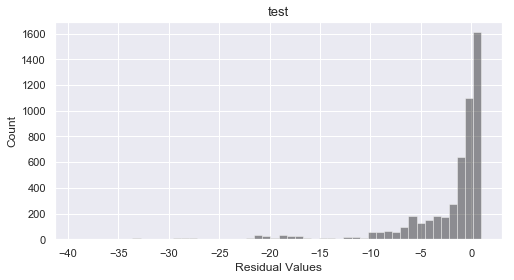

In [314]:
resids = (np.exp(ysvr1_test)-1) - (np.exp(svr_lin.predict(Xsvr1_test))-1)
get_residual_plot(resids, None, 'test')

#### Log-transformed dataset

In [273]:
Xsvr = pd.read_pickle('df_X.pickle')
ysvr = pd.read_pickle('df_y.pickle')

In [274]:
Xsvr.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [277]:
# train, test, split
Xsvr_train, Xsvr_test, ysvr_train, ysvr_test = train_test_split(Xsvr, ysvr, test_size = .20, random_state = 328)

There are four types of kernel tricks that can be used in a support vector regression. The rbf kernel produce the best $R^2$ value. The sigmoid kernel interestingly produced a $R^2$ value that is negative and smaller than -1.

In [278]:
# linear kernel
start =time.time()
svr_lin = SVR(kernel = 'linear')
svr_lin.fit(Xsvr_train, ysvr_train)
print(f"R-squared of train set (linear): {svr_lin.score(Xsvr_train, ysvr_train)}")
print(f"R-squared of test set (linear): {svr_lin.score(Xsvr_test, ysvr_test)}")
end =time.time()
print(f"Execution time = {end-start}")

R-squared of train set (linear): 0.30156091810714125
R-squared of test set (linear): 0.3027509131902354
Execution time = 66.06029486656189


In [279]:
# rbf kernel
start =time.time()
svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(Xsvr_train, ysvr_train)
print(f"R-squared of train set (rbf): {svr_rbf.score(Xsvr_train, ysvr_train)}")
print(f"R-squared of test set (rbf): {svr_rbf.score(Xsvr_test, ysvr_test)}")
end =time.time()
print(f"Execution time = {end-start}")

R-squared of train set (rbf): 0.554835406961879
R-squared of test set (rbf): 0.543494917014854
Execution time = 45.12682390213013


In [280]:
# poly kernel
start =time.time()
svr_poly = SVR(kernel = 'poly')
svr_poly.fit(Xsvr_train, ysvr_train)
print(f"R-squared of train set (poly): {svr_poly.score(Xsvr_train, ysvr_train)}")
print(f"R-squared of test set (poly): {svr_poly.score(Xsvr_test, ysvr_test)}")
end = time.time()
print(end-start)

R-squared of train set (poly): 0.5478083008314544
R-squared of test set (poly): 0.5305059375817293
73.17216181755066


In [281]:
# sigmoid kernel
start =time.time()
svr_sig = SVR(kernel = 'sigmoid')
svr_sig.fit(Xsvr_train, ysvr_train)
print(f"R-squared of train set (sigmoid): {svr_sig.score(Xsvr_train, ysvr_train)}")
print(f"R-squared of test set (sigmoid): {svr_sig.score(Xsvr_test, ysvr_test)}")
end = time.time()
print(end-start)

R-squared of train set (sigmoid): -779.3971273438801
R-squared of test set (sigmoid): -899.1601354668603
68.23404598236084


<i>Gridsearch</i>

In addition to the kernel type, we can also tune the SVR model by choosing a different value for C. We used GridSearchCV to help us find the best values.

The best parameters it found were: C = 100 and kernel = 'rbf'.

In [282]:
start = time.time()
svr = SVR()
param_grid = {'kernel': ['rbf', 'poly', 'linear'],
            'C': [1,10,100]}
gs_svr = GridSearchCV(svr, param_grid, cv=3)
gs_svr.fit(Xsvr_train, ysvr_train)
end = time.time()
print(f"Execution time: {end-start}")

KeyboardInterrupt: 

In [283]:
gs_svr.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [284]:
# with best parameters: {'C': 100, 'kernel': 'rbf'}
start = time.time()
svr_rbf_100 = SVR(kernel = 'rbf', C = 100)
svr_rbf_100.fit(Xsvr_train, ysvr_train)
print(f"R-squared of train set (rbf_100): {svr_rbf_100.score(Xsvr_train, ysvr_train)}")
print(f"R-squared of test set (rbf_100): {svr_rbf_100.score(Xsvr_test, ysvr_test)}")
end = time.time()
print(end-start)

R-squared of train set (rbf_100): 0.7537679983866128
R-squared of test set (rbf_100): 0.6700908525141764
214.78677415847778


In [285]:
svr_rbf_100_test_preds = svr_rbf_100.predict(Xsvr_test)

In [315]:
#root-mean-square-error on the test data
rmse_svr_rbf_100 = sqrt(mean_squared_error(np.exp(ysvr_test)-1, np.exp(svr_rbf_100_test_preds)-1))
rmse_svr_rbf_100

14.15402790900203

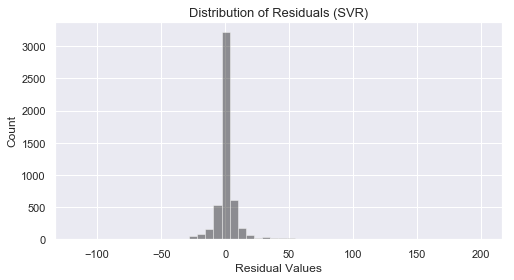

In [316]:
# plot distribution of residuals
svr_rbf_100_residuals = (np.exp(ysvr_test)-1) - (np.exp(svr_rbf_100_test_preds)-1)
get_residual_plot(svr_rbf_100_residuals , None, "Distribution of Residuals (SVR)")

***
<a id='random'></a>
## 4. Random Forest Regression

#### MinMax Scaled Data

The training set performed as well as the log-transformed dataset above but the test set did not do well ($R^2$ = 0.57 vs. 0.77 below) meaning the model extremely overfitted to the test data with the min-max scaled data.

However, if we look at the residual plot, it looks like most of the data is centered around zero which is good. There is large number of data with a negative residual, meaning the model has a tendency to overpredict slightly. 

In [156]:
Xsvr1_train.columns

Index(['has_event_fee', 'has_event_photo', 'num_members', 'num_past_events',
       'event_duration', 'event_descrip_num_words', 'group_yrs_est',
       'num_close_subways', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'book-clubs', 'career-business',
       'cars-motorcycles', 'community-environment', 'dancing',
       'education-learning', 'fashion-beauty', 'fitness', 'food-drink',
       'games', 'government-politics', 'health-wellbeing', 'hobbies-crafts',
       'language', 'lgbt', 'lifestyle', 'movies-film', 'music',
       'new-age-spirituality', 'outdoors-adventure', 'paranormal',
       'parents-family', 'pets-animals', 'photography', 'religion-beliefs',
       'sci-fi-fantasy', 'singles', 'socializing', 'sports-recreation',
       'support', 'tech', 'writing'],
      dtype='object')

In [157]:
rf_minmax = RandomForestRegressor(max_depth=19, random_state=0, n_estimators=100, criterion = 'mse')
rf_minmax.fit(Xsvr1_train, ysvr1_train)
print(f"R-squared of train set: {rf_minmax.score(Xsvr1_train, ysvr1_train)}")
print(f"R-squared of test set: {rf_minmax.score(Xsvr1_test, ysvr1_test)}")

R-squared of train set: 0.9372920770193011
R-squared of test set: 0.5914533029871721


In [158]:
rmse_minmax = sqrt(mean_squared_error(ysvr1_test, rf_minmax.predict(Xsvr1_test)))
print(f'RMSE of MinMax-scaled data: {rmse_minmax}')

RMSE of MinMax-scaled data: 0.024944153242699895


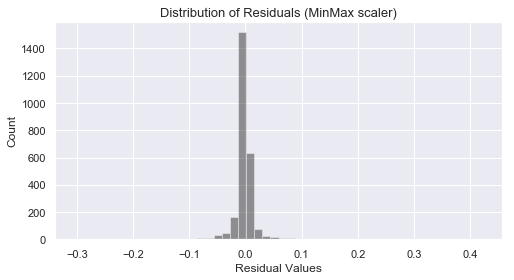

In [159]:
minmax_residuals = ysvr1_test - rf_minmax.predict(Xsvr1_test)
get_residual_plot(minmax_residuals, None, 'Distribution of Residuals (MinMax scaler)')

In [160]:
# saving the minmaxscaled random forest model for testing:
pickle.dump(rf_minmax, open('rf_minmax_57.sav', 'wb'))

#### Log-transformed Data

The log-transformed data did well on the test set.

In [331]:
Xrf = pd.read_pickle('df_X.pickle')
yrf = pd.read_pickle('df_y.pickle')
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, test_size = .20, random_state = 328)

In [333]:
Xrf.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [334]:
start = time.time()
rf_reg = RandomForestRegressor(max_depth=19, random_state=0, n_estimators=100, criterion = 'mse')
rf_reg.fit(Xrf_train, yrf_train)
print(f"R-squared of train set: {rf_reg.score(Xrf_train, yrf_train)}")
print(f"R-squared of test set: {rf_reg.score(Xrf_test, yrf_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.9564794182836361
R-squared of test set: 0.8273738293963089
9.551389932632446


<i>Gridsearch</i>

Gridsearch on the log-transformed dataset. As we see below, the deeper the tree, the higher the $R^2$ value is. However, we do not want to have trees that are too deep as it could be at risk of overfitting to the data.

In [344]:
start = time.time()
rf = RandomForestRegressor(random_state = 0)
param_grid = {'n_estimators': [100,200,300],
            'max_depth': [9,10,12,14],
             'min_samples_split': [2, 4]}
gs_rf = GridSearchCV(rf, param_grid, cv=3)
gs_rf.fit(Xrf_train, yrf_train)
end = time.time()
print(f"Execution time: {end-start}")

KeyboardInterrupt: 

In [295]:
gs_rf.best_params_

{'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 300}

In [346]:
# with params: {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 300}
start = time.time()
rf_reggs00 = RandomForestRegressor(max_depth=14 , random_state=0, n_estimators= 300, min_samples_split = 2)
rf_reggs00.fit(Xrf_train, yrf_train)
print(f"R-squared of train set: {rf_reggs00.score(Xrf_train, yrf_train)}")
print(f"R-squared of test set: {rf_reggs00.score(Xrf_test, yrf_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.8840583558897653
R-squared of test set: 0.7821919974275087
24.969606161117554


In [336]:
# with params: {'max_depth'=21, 'n_estimators'=200, 'min_samples_split' = 4}
start = time.time()
rf_reggs2 = RandomForestRegressor(max_depth=21, random_state=0, n_estimators=200, criterion = 'mse', min_samples_split = 4, random_state =0)
rf_reggs2.fit(Xrf_train, yrf_train)
print(f"R-squared of train set: {rf_reggs2.score(Xrf_train, yrf_train)}")
print(f"R-squared of test set: {rf_reggs2.score(Xrf_test, yrf_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.9570933246346973
R-squared of test set: 0.8301516911079923
20.195560932159424


In [337]:
# predicted test values
rf_reggs00_test_preds = rf_reggs00.predict(Xrf_test)

In [338]:
#root-mean-square-error on the test data
rmse_rf = sqrt(mean_squared_error(np.exp(yrf_test)-1, np.exp(rf_reggs00_test_preds)-1))
rmse_rf

13.97400838503243

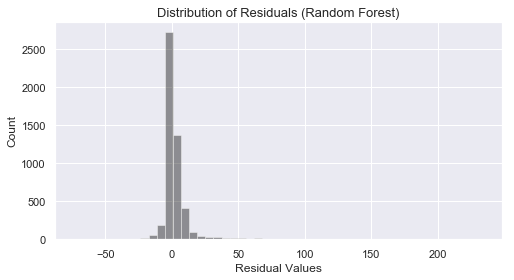

In [339]:
# plot distribution of residuals
rf_residuals = (np.exp(yrf_test)-1) - (np.exp(rf_reggs00_test_preds)-1)
get_residual_plot(rf_residuals , None, "Distribution of Residuals (Random Forest)")

For the best-performing Random Forest model, the top three most important features were:
1. number of members in group
2. number of past events held by group
3. number of days between when the event was created and held 

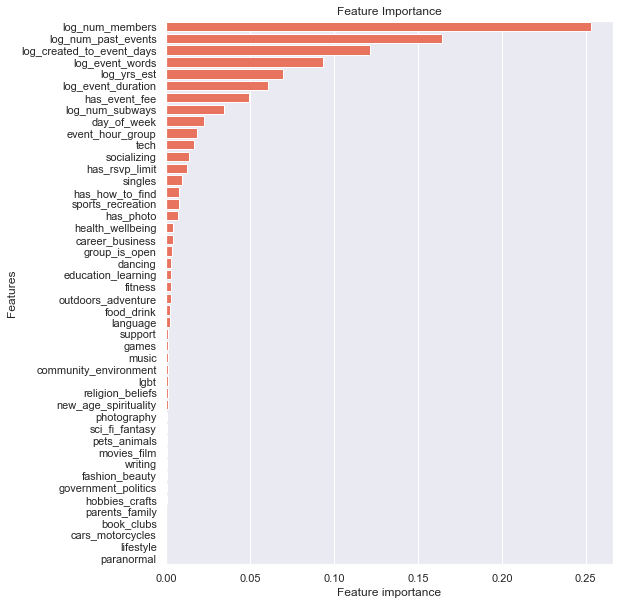

In [340]:
# taking a look at feature importance in the rf_reggs model
plot_feature_importances(rf_reggs00, Xrf_train)

***
<a id='boost'></a>
## 5. XGBoost Regression

In [5]:
# need to specify this to prevent kernel from dying when working with XGboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
Xg = pd.read_pickle('df_X.pickle')
yg = pd.read_pickle('df_y.pickle')
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size = .20, random_state = 328)

In [7]:
Xg.shape

(25424, 46)

In [343]:
Xg.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [347]:
# xgboost.XGBRegressor
start = time.time()
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, max_depth=2, random_state=0)
xgb.fit(Xg_train, yg_train)
print(f"R-squared of train set: {xgb.score(Xg_train, yg_train)}")
print(f"R-squared of test set: {xgb.score(Xg_test, yg_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.46823345604381206
R-squared of test set: 0.4656861100731306
2.092254877090454


<i>GridSearchCV</i>

Conduct a gridsearch on the training data to find optimal values for the hyperparameters.

In [348]:
start = time.time()
xgb_ = xgboost.XGBRegressor(random_state=0)
param_grid = {'n_estimators': [100,200,300],
              'max_depth': [8,9,10],
              'gamma':[0,2,4],
              'learning_rate':[0.02, 0.05, 0.1]}
gs_xgb = GridSearchCV(xgb_, param_grid, cv=3)
gs_xgb.fit(Xg_train, yg_train)
end = time.time()
print(f"Execution time: {end-start}")

Execution time: 3209.8210048675537


In [94]:
Xg_train.columns

Index(['has_event_fee', 'has_event_photo', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'arts_culture', 'book_clubs',
       'career_business', 'cars_motorcycles', 'community_environment',
       'dancing', 'education_learning', 'fashion_beauty', 'fitness',
       'food_drink', 'games', 'government_politics', 'health_wellbeing',
       'hobbies_crafts', 'language', 'lgbt', 'lifestyle', 'movies_film',
       'music', 'new_age_spirituality', 'outdoors_adventure', 'paranormal',
       'parents_family', 'pets_animals', 'photography', 'religion_beliefs',
       'sci_fi_fantasy', 'singles', 'socializing', 'sports_recreation',
       'support', 'tech', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday'],
      dtype='object')

In [349]:
gs_xgb.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}

In [350]:
# with best params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
start = time.time()
gs_xgb_ = xgboost.XGBRegressor(n_estimators=300, gamma=0, max_depth=9, random_state=0, learning_rate=0.1)
gs_xgb_.fit(Xg_train, yg_train)
print(f"R-squared of train set: {gs_xgb_.score(Xg_train, yg_train)}")
print(f"R-squared of test set: {gs_xgb_.score(Xg_test, yg_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.9703586868912241
R-squared of test set: 0.8459473995169202
27.54958987236023


In [ ]:
gs_xgb_.

With the parameters {'gamma': 2, 'max_depth': 19, 'n_estimators': 200} in the model below, there is a smaller difference in $R^2$ between the train and test sets however max_depth of 19 is not ideal as it means the model could be overfitted to this particular dataset.

We'll go with the XGboost model above with max_depth = 8 as our final, best-performing model.

In [351]:
# with params: {'gamma': 2, 'max_depth': 19, 'n_estimators': 200}
start = time.time()
gs_xgb1 = xgboost.XGBRegressor(n_estimators=200, gamma=2, max_depth=19, random_state=0)
gs_xgb1.fit(Xg_train, yg_train)
print(f"R-squared of train set: {gs_xgb1.score(Xg_train, yg_train)}")
print(f"R-squared of test set: {gs_xgb1.score(Xg_test, yg_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.9193123863067804
R-squared of test set: 0.8224955159618546
36.7370867729187


In [390]:
Xg_train.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

Saving best performing model to test new unseen data.

In [389]:
# save the model to disk
pickle.dump(gs_xgb_, open('gs_xgb_85.sav', 'wb'))
 
# load the model from disk
# loaded_model = pickle.load(open('gs_xgb_78.sav', 'rb'))

In [353]:
# predicted test values
xgb_test_preds = gs_xgb_.predict(Xg_test)

In [355]:
#root-mean-square-error on the test data
rmse_xgb = sqrt(mean_squared_error(np.exp(yg_test)-1, np.exp(xgb_test_preds)-1))
rmse_xgb

12.31115507037091

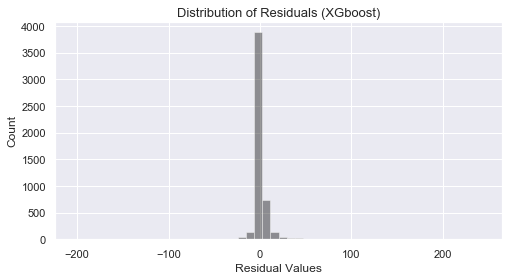

In [356]:
# plot distribution of residuals
xgb_residuals = (np.exp(yg_test)-1) - (np.exp(xgb_test_preds)-1)
get_residual_plot(xgb_residuals , None, "Distribution of Residuals (XGboost)")

<i>Feature Importance</i>

For the final XGboost model, the three most important features were:
1. number of days between event created & event itself
2. number of words in event description
3. number of members in group

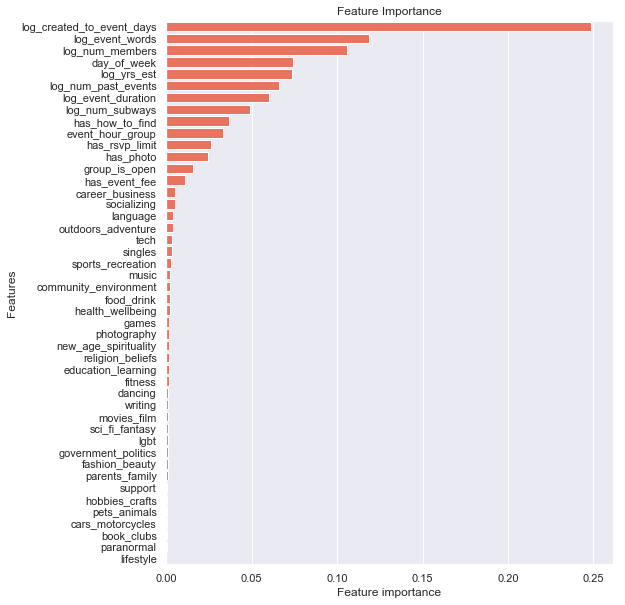

In [357]:
# taking a look at feature importance in the final model
plot_feature_importances(gs_xgb_, Xg_train)

***
<a id='sgd'></a>
## 6. SGD Regression

In [358]:
Xsg = pd.read_pickle('df_X.pickle')
ysg = pd.read_pickle('df_y.pickle')

In [359]:
Xsg_train, Xsg_test, ysg_train, ysg_test = train_test_split(Xsg, ysg, test_size = .20, random_state = 328)

In [370]:
start = time.time()
sgd = SGDRegressor(random_state=0)
sgd.fit(Xsg_train, ysg_train)
print(f"R-squared of train set: {sgd.score(Xsg_train, ysg_train)}")
print(f"R-squared of test set: {sgd.score(Xsg_test, ysg_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.30366088363026644
R-squared of test set: 0.31404522343334973
0.032089948654174805


<i>GridSearchCV</i>

In [364]:
start = time.time()
sgd = SGDRegressor(random_state=0)
param_grid = {'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
            'loss': ['squared_loss','huber', 'epsilon_insensitive','squared_epsilon_insensitive' ],
             'penalty': ['l1', 'l2', 'elasticnet'],
             'alpha': [0.0001, 0.0002, 0.00001]}
gs_sgd = GridSearchCV(sgd, param_grid, cv=3)
gs_sgd.fit(Xsg_train, ysg_train)
end = time.time()
print(f"Execution time: {end-start}")

Execution time: 11.522716045379639


Best params suggested are the same as the default values that we initially tested. Adjust values and hyperparamters in the gridsearch.

In [365]:
gs_sgd.best_params_

{'alpha': 0.0002,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'penalty': 'l1'}

In [368]:
# with best_params: {'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'l1', 'alpha': 0.0002}
start = time.time()
sgd0 = SGDRegressor(random_state=0, learning_rate = 'invscaling', loss = 'squared_loss', penalty = 'l1', alpha= 0.0002)
sgd0.fit(Xsg_train, ysg_train)
print(f"R-squared of train set: {sgd0.score(Xsg_train, ysg_train)}")
print(f"R-squared of test set: {sgd0.score(Xsg_test, ysg_test)}")
end = time.time()
print(end-start)

R-squared of train set: 0.30219551706339415
R-squared of test set: 0.3127299873072271
0.04311704635620117


In [371]:
sgd_test_preds = sgd.predict(Xsg_test)

In [373]:
#root-mean-square-error on the test data
rmse_sgd = sqrt(mean_squared_error(np.exp(ysg_test)-1, np.exp(sgd_test_preds)-1))
rmse_sgd

19.34083767528674

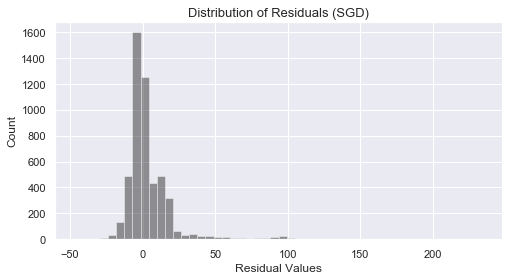

In [374]:
# plot distribution of residuals
sgd_residuals = (np.exp(ysg_test)-1) - (np.exp(sgd_test_preds)-1)
get_residual_plot(sgd_residuals , None, "Distribution of Residuals (SGD)")

***
<a id='stacked'></a>
## 7. Stacked Model

Model stacking is the process of taking two or more models and using the predictions of those models as features in another model.

Here, I build a number of 'weak' models that are trained on different subsets/mix of features and stack them into a Linear Regression model and a regularization regression (either ridge or lasso).

<u>Basemodels:</u>
1. Linear Regression
2. XGB Regression
3. Random Forest Regression
4. Support Vector Regression

<u>Stacked Model:</u>
- Linear Regression

In [375]:
X_stack = pd.read_pickle('df_X.pickle')
y_stack = pd.read_pickle('df_y.pickle')
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_stack,y_stack,test_size = 0.2, random_state=328)

In [376]:
Xs_train.columns

Index(['group_is_open', 'has_how_to_find', 'has_rsvp_limit', 'has_photo',
       'day_of_week', 'event_hour_group', 'has_event_fee', 'log_num_members',
       'log_num_past_events', 'log_event_duration', 'log_event_words',
       'log_yrs_est', 'log_num_subways', 'log_created_to_event_days',
       'book_clubs', 'career_business', 'cars_motorcycles',
       'community_environment', 'dancing', 'education_learning',
       'fashion_beauty', 'fitness', 'food_drink', 'games',
       'government_politics', 'health_wellbeing', 'hobbies_crafts', 'language',
       'lgbt', 'lifestyle', 'movies_film', 'music', 'new_age_spirituality',
       'outdoors_adventure', 'paranormal', 'parents_family', 'pets_animals',
       'photography', 'religion_beliefs', 'sci_fi_fantasy', 'singles',
       'socializing', 'sports_recreation', 'support', 'tech', 'writing'],
      dtype='object')

In [381]:
# combining the predictions of 4 models (XGB, RF, SVR) into one matrix to use as the X_train and X_test sets
X_train_stacked = np.concatenate((np.array([gs_xgb_.predict(Xs_train)]).T, np.array([rf_reggs00.predict(Xs_train)]).T, np.array([svr_rbf_100.predict(Xs_train)]).T), axis = 1)
X_test_stacked = np.concatenate((np.array([gs_xgb_.predict(Xs_test)]).T, np.array([rf_reggs00.predict(Xs_test)]).T, np.array([svr_rbf_100.predict(Xs_test)]).T), axis = 1)


In [382]:
# checking the shape to make sure the arrays concatenated correctly
print(X_train_stacked.shape)
print(X_test_stacked.shape)

(20339, 3)
(5085, 3)


In [383]:
stacked_lr = LinearRegression()
stacked_lr.fit(X_train_stacked, ys_train)
stacked_lr.coef_

array([ 1.24836878, -0.14296956, -0.09515998])

In [384]:
stacked_preds = stacked_lr.predict(X_test_stacked)
stacked_r2 = stacked_lr.score(X_test_stacked, ys_test)

In [385]:
stacked_r2

0.8430655272550763

In [387]:
# RMSE of test stacked
stacked_rmse = sqrt(mean_squared_error(np.exp(ys_test)-1, np.exp(stacked_preds)-1))
stacked_rmse

12.429286044569324

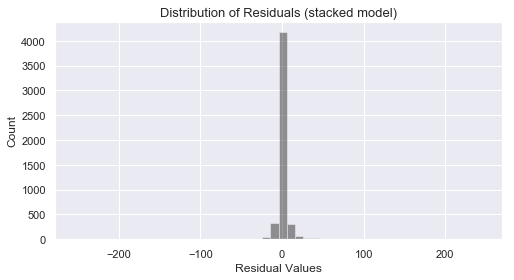

In [388]:
stacked_residuals = (np.exp(ys_test)-1) - (np.exp(stacked_preds)-1)
get_residual_plot(stacked_residuals, None, 'Distribution of Residuals (stacked model)')

In [406]:
pickle.dump(stacked_lr, open('stacked_lr.sav', 'wb'))